# Project 3: Web APIs & NLP
_Author: Choo Wende_

_Date: 28 Jul 2022_

-------

## Content

**Part 1**: Webscrapping & Data Cleaning 

1. Webscrapping
    - API Set-up
    - Retrieve JSON
    - Overview of subreddits
    - Build up data set
   
2. Data Cleaning
    - Clean dataframe
    - Combine and export data set
    
**Part 2**: Exploratory Data Analysis (EDA), Data Processing & Modelling
1. [EDA](#1.-Exploratory-Data-Analysis)
    - create new column combining title and selftext
    - top 10 recurring words in each subreddits
    - sentiment analysis of each subreddits

2. [Data Pre-processing](#2.-Data-Pre-processing)
    - labelling subreddits
    - removing HTML, website addresses, non-letters, stopwords
    - stemming

3. [Classification Modellling](#3.-Classification-Modelling)
    - Baseline Accuracy
    - Base model
    - Logistic Regression Model with Cvec/Tvec
    - Naive-Bayes Model with Cvec/Tvec
    - Overview of all models
    - Evaluation
    
4. [Recommendations and Future Works](#4.-Recommendations-and-Future-Works)
    - Recommended classification model
    - Proposal to Attract Travellers
    - Future Works

5. [Conclusion](#5.-Conclusion)


**Subreddits**
1. [AustraliaTravel](https://www.reddit.com/r/AustraliaTravel/)
2. [Roadtrip](https://www.reddit.com/r/roadtrip/)
3. [TravelHacks](https://www.reddit.com/r/TravelHacks/)
4. [TravelNoPics](https://www.reddit.com/r/TravelNoPics/)
5. [Travel](https://www.reddit.com/r/travel/)


## Libraries
All libraries are imported here.

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# import requests
# import time


# import scipy.stats as stats
# %matplotlib inline

# #Stylistic Choice:
# plt.style.use('fivethirtyeight')
# sns.set_style('darkgrid')

# # modeling imports
# from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
# from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
# from sklearn import metrics
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, \
plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# %config InlineBackend.figure_format = 'retina'
# %matplotlib inline

## Data Set

The data used for this project is as follows:

* [`combined_posts.csv`](./datasets/combined_posts.csv): Submissions data scrapped from [roadtrip](https://www.reddit.com/r/roadtrip/) and [TravelHacks](https://www.reddit.com/r/TravelHacks/) subreddits. 


## Data Dictionary 

**combined_posts data set:**

|Feature|Type|Description|
|---|---|---|
|author|object|This is the author of the submission|
|subreddit|object|This is name of the sub-reddits|
|selftext|object|This is the main content of the submissions in the sub-reddits|
|title|object|This is the title of the sub-reddits|
|created_utc|integers|This is the time of submission creation in Unix epoch format|




## 1. Exploratory Data Analysis

### Import the dataset

In [2]:
# reading data  
combined_posts = pd.read_csv('../datasets/combined_posts.csv')

In [3]:
# Display dataframe summary info.
combined_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2614 entries, 0 to 2613
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    2614 non-null   object
 1   author       2614 non-null   object
 2   selftext     2614 non-null   object
 3   title        2614 non-null   object
 4   created_utc  2614 non-null   object
dtypes: object(5)
memory usage: 102.2+ KB


In [4]:
# Display first 5 rows and last 5 rows of dataframe.
combined_posts

,subreddit,author,selftext,title,created_utc
0,TravelHacks,Remarkable_Lie_8622,Have you any experience booking a roundtrip ti...,How do you book a roundtrip but a different ci...,2022-07-19 21:41:24
1,TravelHacks,kastelu,Hi everyone! Next month I'll be visiting my co...,What to do in London in 15+ hours?,2022-07-19 21:04:48
2,TravelHacks,Avocadosandtomatoes,I’m not too particular on the destination. I j...,Is there a way to search cheap flights coming ...,2022-07-19 20:39:03
3,TravelHacks,monarchal,"I just need to be there Saturday, would be nic...",Where’s the cheapest place to get a flight fro...,2022-07-19 18:45:22
4,TravelHacks,Small-Decision8803,Which would you choose for vacation? I’ve neve...,Seattle vs denver,2022-07-19 18:28:38
...,...,...,...,...,...
2609,roadtrip,_princess-galaxia_,\n\n[View Poll](https://www.reddit.com/poll/si...,Often told I drive too much. What's the averag...,2022-02-02 05:54:33
2610,roadtrip,Marokiii,Either driving time or actual distance travele...,What's your sweet spot for AVERAGE daily drivi...,2022-02-02 03:26:20
2611,roadtrip,SlothGeo,I’ve decided to take a road trip with my three...,First come/First Serve camping near Redwoods?,2022-02-02 03:22:12
2612,roadtrip,1AXC,I’m from Southern California and want to just ...,Can anyone suggest where to road trip to for g...,2022-02-01 21:33:00


### Create new column combining `selftext` and `title`

The new column combine the content in the `selftext` and the `title` so that both content may be processed together later in the project.

In [5]:
# create new column that combine selftext and title. 
combined_posts['selftext_title'] = combined_posts['selftext'] + ' ' + combined_posts['title']

In [6]:
# Display first 5 rows of data frame.
combined_posts.head()

,subreddit,author,selftext,title,created_utc,selftext_title
0,TravelHacks,Remarkable_Lie_8622,Have you any experience booking a roundtrip ti...,How do you book a roundtrip but a different ci...,2022-07-19 21:41:24,Have you any experience booking a roundtrip ti...
1,TravelHacks,kastelu,Hi everyone! Next month I'll be visiting my co...,What to do in London in 15+ hours?,2022-07-19 21:04:48,Hi everyone! Next month I'll be visiting my co...
2,TravelHacks,Avocadosandtomatoes,I’m not too particular on the destination. I j...,Is there a way to search cheap flights coming ...,2022-07-19 20:39:03,I’m not too particular on the destination. I j...
3,TravelHacks,monarchal,"I just need to be there Saturday, would be nic...",Where’s the cheapest place to get a flight fro...,2022-07-19 18:45:22,"I just need to be there Saturday, would be nic..."
4,TravelHacks,Small-Decision8803,Which would you choose for vacation? I’ve neve...,Seattle vs denver,2022-07-19 18:28:38,Which would you choose for vacation? I’ve neve...


### TravelHacks Subreddit
1. One anomaly was observed on the number of submissions by users. Although the user, 'wallpapersdance', submits significantly higher number of posts and on a regular basis, from Feb 2022 to Jun 2022, from the titles of his submissions, he seems to be planning a trip to Greece and his submissions seem genuine. Hence, his submissions were kept.
2. From the top 10 occurring words, two of the words observed were 'want' and 'need'. They may mean the same thing in the context of the submissions. 
3. 'flight' is one of the top recurring words. It may be inferred that one of the key discussions in TravelHacks is 'flight' related.
4. Submissions with index 12, 488, 587, 719, 1175, 1236 may be relevant to travelling in australia. 
    - Of the seven submissions, four submissions are related to cost of car rental, included incurring additional cost due to mistakes made by rental company. The project could consider attracting more car rental companies to operate at the airport to provide more economical solutions (increase supply will lower costs). Grading systems for car rental companies would be beneficial for traveller to make better informed decisions and partner with a more trustworthy rental company. 
    - Two of the submissions were related to COVID test results. Travellers were worried about testing positive during the trip. The project can explore formulating policy to support travellers who are tested positively to recoup some of the costs incurred during planning or to delay their trip

#### Review Number of Submissions based on Users
It is observed that there is a user who submits significantly higher number of posts and on a regular basis, from Feb 2022 to Jun 2022. From titles of his submissions, he seems to be planning a trip to Greece. Hence his posts will be kept as they seem genuine. 

In [7]:
travelhacks_df=combined_posts[combined_posts['subreddit']=='TravelHacks'].copy()
travelhacks_df.head()

,subreddit,author,selftext,title,created_utc,selftext_title
0,TravelHacks,Remarkable_Lie_8622,Have you any experience booking a roundtrip ti...,How do you book a roundtrip but a different ci...,2022-07-19 21:41:24,Have you any experience booking a roundtrip ti...
1,TravelHacks,kastelu,Hi everyone! Next month I'll be visiting my co...,What to do in London in 15+ hours?,2022-07-19 21:04:48,Hi everyone! Next month I'll be visiting my co...
2,TravelHacks,Avocadosandtomatoes,I’m not too particular on the destination. I j...,Is there a way to search cheap flights coming ...,2022-07-19 20:39:03,I’m not too particular on the destination. I j...
3,TravelHacks,monarchal,"I just need to be there Saturday, would be nic...",Where’s the cheapest place to get a flight fro...,2022-07-19 18:45:22,"I just need to be there Saturday, would be nic..."
4,TravelHacks,Small-Decision8803,Which would you choose for vacation? I’ve neve...,Seattle vs denver,2022-07-19 18:28:38,Which would you choose for vacation? I’ve neve...


In [8]:
# Review number of submissions by authors.
travelhacks_df['author'].value_counts().head(10)

wallpapersdance       36
Brisingr08             6
Zeffury                6
Desertedfoxx           6
redditusermazafaka     6
jacklychi              5
wefeellike             4
PopNo5397              4
xJavier_Escuellax      4
SadPatient28           3
Name: author, dtype: int64

In [9]:
travelhacks_df[travelhacks_df['author']=='wallpapersdance']

,subreddit,author,selftext,title,created_utc,selftext_title
303,TravelHacks,wallpapersdance,"1. For flights out of the USA, does anything b...",Questions for people who know alot about good ...,2022-06-22 04:49:07,"1. For flights out of the USA, does anything b..."
331,TravelHacks,wallpapersdance,"Gonna fly to Greece, gonna swap out my verizon...",Questions for people who know alot about SIM c...,2022-06-19 05:21:08,"Gonna fly to Greece, gonna swap out my verizon..."
401,TravelHacks,wallpapersdance,"Afraid of accounts freezing, not all allow tra...",USA citizen. Going to Athens Greece. Money is ...,2022-06-10 21:52:04,"Afraid of accounts freezing, not all allow tra..."
454,TravelHacks,wallpapersdance,How do I do this?,USA citizen going to Greece for 3 months. Bank...,2022-06-05 04:22:34,How do I do this? USA citizen going to Greece ...
478,TravelHacks,wallpapersdance,What kind of container? What should you label ...,When you are flying for a long trip and are br...,2022-06-03 03:51:05,What kind of container? What should you label ...
481,TravelHacks,wallpapersdance,I know they are two different countries. So wi...,"If I get a SIM card in Athens Greece arirport,...",2022-06-02 20:39:43,I know they are two different countries. So wi...
486,TravelHacks,wallpapersdance,Are there some kinds of glass more durable (wh...,"When buying a cheap travel phone, what feature...",2022-06-02 14:01:14,Are there some kinds of glass more durable (wh...
523,TravelHacks,wallpapersdance,In USA for example,How much does it cost and how many days should...,2022-05-30 10:42:48,In USA for example How much does it cost and h...
595,TravelHacks,wallpapersdance,I don't understand. There are definitely many ...,Why are Emirates and Turkish Airlines such goo...,2022-05-20 14:33:33,I don't understand. There are definitely many ...
653,TravelHacks,wallpapersdance,"Going to Athens Greece, never left USA before",When you withdraw money from an ATM at an airp...,2022-05-15 02:25:33,"Going to Athens Greece, never left USA before ..."


#### Retrieve Top 10 Recurring Words
1. From the top 10 occurring words, two of the words observed were 'want' and 'need'. They may mean the same thing in the context of the submissions.
2. 'flight' is one of the top recurring words. It may be inferred that one of the key discussions in TravelHacks is 'flight' related.

##### Define find_top10 function
Function aims to find top 10 recurring words in the dataframe columns.

In [10]:
def find_top10(df, stop_words='english'):
    
    # Instantiate a CountVectorizer.
    cvec = CountVectorizer(stop_words=stop_words)
    
    # Instantiate the "CountVectorizer" object, which is sklearn's
    # bag of words tool.
    cvec_title = cvec.fit_transform(df['selftext_title'])
    
    # Convert into Dataframe
    cvec_title = pd.DataFrame(cvec_title.toarray(), 
                              columns=cvec.get_feature_names())
    
    # plot top occuring words
    plt.figure(figsize=(8, 8))
    cvec_title.sum().sort_values(ascending=False).head(10).plot(kind='barh');
    plt.title('Top 10 Occuring Words', size=10);
    
    pass

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


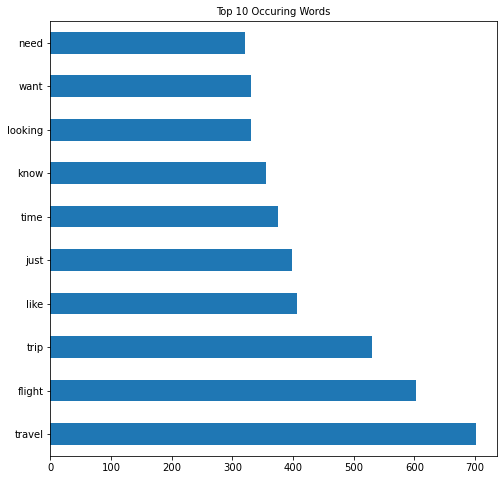

In [11]:
find_top10(travelhacks_df)

#### Sentiment Analysis
Submissions with index 12, 488, 587, 719, 1175, 1236 may be relevant to travelling in australia. 
- Of the six submissions, three submissions are related to cost of car rental, included incurring additional cost due to mistakes made by car rental company. The project could consider attracting more car rental companies to operate at the airport to provide more economical solutions (increase supply will lower costs). Grading systems for car rental companies would be beneficial for traveller to make better informed decisions and partner with a more trustworthy rental company. 
- Two of the submissions were related to COVID test results. Travellers were worried about testing positive during the trip. The project can explore formulating policy to support travellers who are tested positively to recoup some of the costs incurred during planning or to delay their trip. One of which mentioned about insurance coverage. Given the uncertainty of the evolving Covid measures, it is important that travel insurance covers the unfortunate event that a traveller being infected by Covid. The project can consider partnering travel insurance agency to provide such coverage for this event. 

##### Define get_sentiment Function
The function aims to plot the sentiments of the text columns. 

In [12]:
def get_sentiment(df):

    # Instantiate Sentiment Intensity Analyzer
    sent = SentimentIntensityAnalyzer()

    # Create Column to Input Calculated Sentiment
    df['sentiment'] = df['selftext_title'].map(
        lambda text: sent.polarity_scores(text)['compound']
    )
    
    # Plot distribution of sentiments.
    plt.figure(figsize=(8, 8))
    sns.histplot(df['sentiment']);
    plt.axvline(0, color='k', linewidth=1,label='Neutral');
    plt.axvline(df['sentiment'].mean(), 
                color='r', 
                linestyle='dashed', 
                linewidth=1,
                label="Mean Sentiment");
    plt.title(df['subreddit'][0], size=15)
    plt.legend();
        
    return df

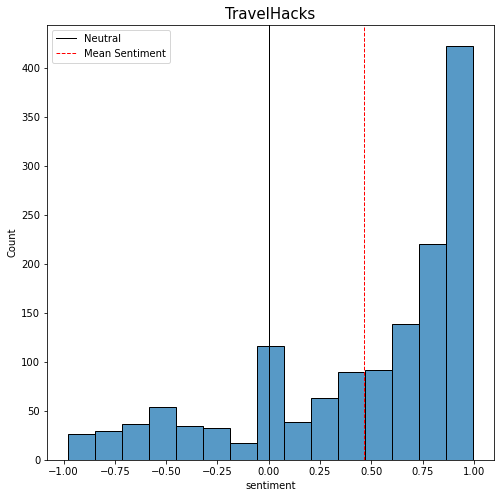

In [13]:
# Get sentiments of 'selftext_title' column
travelhacks_sentiments = get_sentiment(travelhacks_df)

In [14]:
# Display submissions with low sentiment score.
travelhacks_sentiments[travelhacks_sentiments['sentiment'] <-0.9]

,subreddit,author,selftext,title,created_utc,selftext_title,sentiment
12,TravelHacks,ShoeStatus2431,I booked with Agoda in January. The booking co...,Don't book with Agoda - they are scammers,2022-07-19 07:27:49,I booked with Agoda in January. The booking co...,-0.9293
32,TravelHacks,spicyradler,I'm reaching the end of my study abroad progra...,Best way to ship suitcases internationally? (s...,2022-07-17 20:22:28,I'm reaching the end of my study abroad progra...,-0.9047
42,TravelHacks,god_lucky,I had a flight from my country to South Korea ...,"Wrongly refused to check in my Emirates crew, ...",2022-07-17 09:15:31,I had a flight from my country to South Korea ...,-0.9552
145,TravelHacks,Nocturndream,I live in Texas I hate the heat and everything...,I’m so sick of my town,2022-07-07 07:43:25,I live in Texas I hate the heat and everything...,-0.9423
275,TravelHacks,graceeh67,"I’m trying to buy tickets from Missoula, MT to...",Looking for advice on whether to buy now or wa...,2022-06-24 17:18:19,"I’m trying to buy tickets from Missoula, MT to...",-0.9224
276,TravelHacks,CAElite,Hey folks\n\nSo last week I went on a work tri...,"UK &lt;&gt; USA Flight delays, how do I find o...",2022-06-24 14:53:39,Hey folks\n\nSo last week I went on a work tri...,-0.9363
412,TravelHacks,sweetdreamsandbrie,I saw this ad on Facebook from a company calle...,Is 2FN Travel a legitimate business or a scam?,2022-06-10 00:09:23,I saw this ad on Facebook from a company calle...,-0.9220
488,TravelHacks,dingle__berries,Tried posting in r/Travel but auto-rejects thi...,Was told Pre-Paid Rental Car unavailable 1 day...,2022-06-02 04:33:12,Tried posting in r/Travel but auto-rejects thi...,-0.9752
507,TravelHacks,AdmirableManagement2,Are there any ferries that allow dogs from FL ...,How to get my dog to DR from Florida?,2022-05-31 16:03:39,Are there any ferries that allow dogs from FL ...,-0.9420
587,TravelHacks,Kottyforeman22,I prepaid for a reservation for a Car rental f...,How to get compensation from Rental Car compan...,2022-05-23 20:45:03,I prepaid for a reservation for a Car rental f...,-0.9540


In [15]:
# Retrieve selftext of post index 12, 488, 587, 719, 1175, 1236
# they may be relevant to our project.

for i in [12, 488, 587, 719, 1175, 1236]:
    
    selftext = travelhacks_sentiments.iloc[i]['selftext']
    print(f'Index {i}: \n{selftext}\n\n')

Index 12: 
I booked with Agoda in January. The booking confirmation states a EUR amount but in fine print, it says the money will be converted to my local currency (DKK). Well, now the day came when Agoda was to charge the money, and lo-and-behold, they charge +17% on top of the official exchange rate! I've never experienced anything like this. I thought it must be a mistake or related taxes or something but the confirmation stated it was including all taxes (even listed the amounts). I contacted their customer support and they just stated it was all due to Agoda's conversion fee which was stated when I booked. But nowhere was it stated Agoda would put a +17% surcharge on the official conversion fee. I tried to insist and say it must be a mistake but they were unyielding. They just advised me I could cancel the booking. Trouble is, rebooking with another site would be much more expensive - there's a reason I booked 6 months in advance!

I have only one word for this: Fraud. Even if the

### roadtrips Subreddit
1. No anomaly is observed on the number of submissions by the users.
2. Of the top 10 recurring words, 'drive' & 'driving' and 'day' and 'days' were observed. Stemming will be conducted to group these words together so that more distinct words would be included.  
3. Submissions with index 388, 477, 709, 804, 853 may be relevant to travelling in australia. 
    - Two of the submissions, index 388 and 477, are related to safety of driving through areas that may not be safe. The project may review the typical route for road trips in Australia pass through areas that are safe. Police stations could be situated at intervals along the typical routes to assure travellers or assist travellers if needed. 
    - Two of the submissions, index 709 and 804, are related to long drive and are concern about the effects of having long drive. The project may considor building attractions or amenities pit stop along typical scenic route in Australia so that travellers could take breaks in between long drives.    


#### Review Number of Submissions based on Users
No anomaly is observed on the number of submissions by the users.

In [16]:
roadtrip_df=combined_posts[combined_posts['subreddit']=='roadtrip'].copy()
roadtrip_df.reset_index(inplace=True)
roadtrip_df.head()

,index,subreddit,author,selftext,title,created_utc,selftext_title
0,1412,roadtrip,Craig_Bryant,We're planning a Pacific Coast road trip in Se...,Pacific Coast road trip,2022-07-20 02:47:45,We're planning a Pacific Coast road trip in Se...
1,1413,roadtrip,mattynapps,The wife and I are moving from the SF Bay Area...,Moving cross country,2022-07-20 02:44:16,The wife and I are moving from the SF Bay Area...
2,1414,roadtrip,veg4npoutine,"My family and I are from Calgary, Canada, and...",Ideas for a trip from Calgary to LA and Vegas?,2022-07-20 02:37:27,"My family and I are from Calgary, Canada, and..."
3,1415,roadtrip,dustyfrothman,I'm about to start a long motorcycle road trip...,From MA to SC. Must stop places along Skyline ...,2022-07-20 00:17:37,I'm about to start a long motorcycle road trip...
4,1416,roadtrip,snowboarding420,Heading south this Friday and curious which wa...,495 around DC or 15 to 17,2022-07-20 00:00:26,Heading south this Friday and curious which wa...


In [17]:
# Review number of submissions by authors.
roadtrip_df['author'].value_counts().head(10)

imenmyself1234       6
traspo_              4
Gregory_Brady        4
TheG8Uniter          4
CraftyPumpkin1861    4
HouseOfBamboo2       3
raygan_reddit        3
AwayWeGo50           3
aspendegie           3
LNAKEIAD82           3
Name: author, dtype: int64

#### Retrieve Top 10 Recurring Words
Of the top 10 recurring words, 'drive' & 'driving' and 'day' and 'days' were observed. Stemming will be conducted to group these words together so that more distinct words would be included.

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


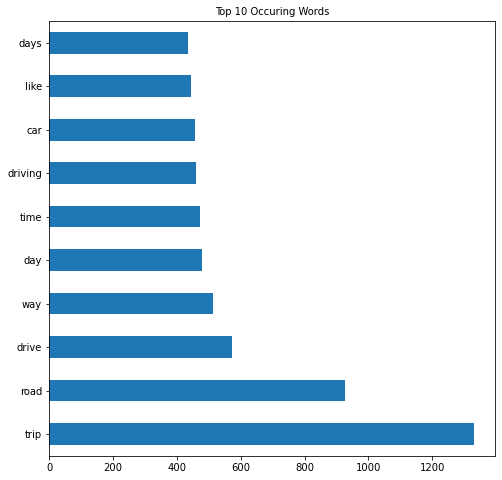

In [18]:
find_top10(roadtrip_df)

#### Sentiment Analysis
Submissions with index 399, 476, 709, 801, 850 may be relevant to travelling in australia. 
- Two of the submissions, index 399 and 476, are related to safety of driving through areas that may not be safe. The project may review the typical route for road trips in Australia pass through areas that are safe. Police stations could be situated at intervals along the typical routes to assure travellers or assist travellers if needed. 
- Two of the submissions, index 709 and 801, are related to long drive and are concern about the effects of having long drive. The project may considor building attractions or amenities pit stop along typical scenic route in Australia so that travellers could take breaks in between long drives.    

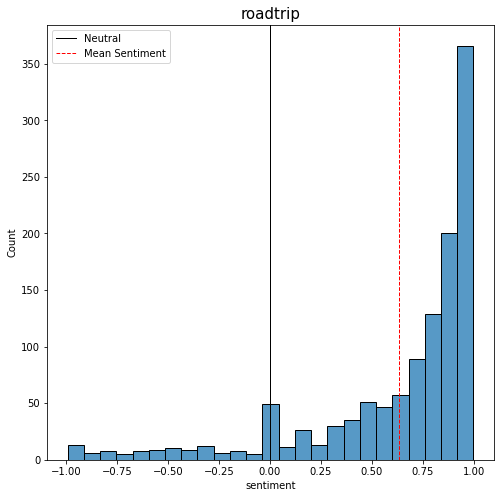

In [19]:
# Get sentiments of 'selftext_title' column
roadtrip_sentiments = get_sentiment(roadtrip_df)

In [20]:
# Display submissions with low sentiment score.
roadtrip_sentiments[roadtrip_sentiments['sentiment'] <-0.9]

,index,subreddit,author,selftext,title,created_utc,selftext_title,sentiment
34,1446,roadtrip,SRV1981,"From New York, made it to Denver Friday. Withi...",Altitude sickness - Need Route Advice,2022-07-17 11:16:49,"From New York, made it to Denver Friday. Withi...",-0.9794
192,1604,roadtrip,TheUnluckyGamer13,Since this will probably be my last long vacat...,Roadtrip from Seattle to Salt Lake city as a t...,2022-06-25 05:20:00,Since this will probably be my last long vacat...,-0.9356
219,1631,roadtrip,Lee10190,It used to be when someone passed away (celebr...,"Why is it ""fashionable"" to announce deaths in ...",2022-06-21 22:23:09,It used to be when someone passed away (celebr...,-0.9774
399,1811,roadtrip,ladytenacity,"It was 11 pm at night, and I was driving 80 mp...",tailgated in right lane by two cars with their...,2022-05-30 06:56:15,"It was 11 pm at night, and I was driving 80 mp...",-0.9832
401,1813,roadtrip,sunnydog1969,Current itinerary but open for suggestions \nD...,"Advice needed for Dallas,TX to South Dakota ro...",2022-05-30 03:53:48,Current itinerary but open for suggestions \nD...,-0.9343
476,1888,roadtrip,Exciting_Animal3141,me and my mom are driving 26 hours to see fami...,scared to go on road trip,2022-05-19 03:40:52,me and my mom are driving 26 hours to see fami...,-0.9485
581,1993,roadtrip,staticlens,"Wanted to see if this itinerary is feasible, i...",Las Vegas to Death Valley - Trip Itinerary,2022-05-01 18:47:35,"Wanted to see if this itinerary is feasible, i...",-0.9705
588,2000,roadtrip,No_Personality2566,I live in the worst city in America. Cleveland...,I've had it. I'm leaving.,2022-05-01 13:53:40,I live in the worst city in America. Cleveland...,-0.9600
683,2095,roadtrip,Self_Batterment,I love guns but I’m not a total gun nut and of...,Driving from middle of Texas to Arizona and am...,2022-04-20 10:41:07,I love guns but I’m not a total gun nut and of...,-0.9383
709,2121,roadtrip,Hisokasfatjucybussy,I’m on a car trip for my grandpa’s funeral and...,My ass is numb,2022-04-15 04:05:12,I’m on a car trip for my grandpa’s funeral and...,-0.9398


In [21]:
# Retrieve selftext of post index 399, 476, 709, 801, 850
# they may be relevant to our project.

for i in [399, 476, 709, 801, 850]:
    
    selftext = roadtrip_sentiments.iloc[i]['selftext']
    print(f'Index {i}: \n{selftext}\n\n')

Index 399: 
It was 11 pm at night, and I was driving 80 mph down Interstate 25, in New Mexico. I am driving in the left (passing) lane, when I notice two cars coming up in the distance fast, both with their brights on. I move to the right (slow) lane to let them pass, which they both do. After passing me and the car in front of me at a high speed, the first car (Gray Sedan) then cuts in front of the car in front of me, and then slows down, and the second car (White Van) immediately squeezes in between gray sedan and the car in front of me. White Van is following very closely and aggressively behind gray sedan. I notice this as strange behavior but continue to drive... both have slowed down but I am reluctant to pass them. Finally, I decide I want to lose them, so I pass them going 90 mph and hope to lose them because I am uncomfortable driving ahead of them with them both having their brights on. I stay ahead of them for a bit, until gray sedan suddenly speeds past me, only to cut me o

### Preliminary Assessments
1. In TravelHacks subreddit, one anomaly was observed on the number of submissions by users. Although the user, 'wallpapersdance', submits significantly higher number of posts and on a regular basis, from Feb 2022 to Jun 2022, from the titles of his submissions, he seems to be planning a trip to Greece and his submissions seem genuine. Hence, his submissions were kept.
2. Some words like 'drive' & 'driving' and 'day' and 'days' were observed. Stemming will be conducted to group these words together so that more distinct words would be included.
3. The word 'trip' is one of the top 10 recurring word in both TravelHacks and roadtrip subreddit. It may not be meaningful to keep the word for modelling. It will be included in the list of stopwords. 
4. From TravelHacks, key discussions revolves around 'flight'. From roadtrip, 'road', 'drive' and 'car' were discussed frequently. Therefore, the project can explore addressing flight, cars and drive concerns to attract travellers who enjoy road trips. For example, bundle deals that consists of flight tickets and car rental will provide traveller the convenience, which will entice them to choose Australia as an ideal destination. 
5. In general, the sentiment of the submissions in both TravelHacks and roadtrip subreddits are highly positive. 
    - TravelHacks:
        - Of the six submissions, three submissions are related to cost of car rental, included incurring additional cost due to mistakes made by rental company. The project could consider attracting more car rental companies to operate at the airport to provide more economical solutions (increase supply will lower costs). Grading systems for car rental companies would be beneficial for traveller to make better informed decisions and partner with a more trustworthy rental company. 
        - Two of the submissions were related to COVID test results. Travellers were worried about testing positive during the trip. The project can explore formulating policy to support travellers who are tested positively to recoup some of the costs incurred during planning or to delay their trip
    - roadtrip:
        - Two of the submissions, index 388 and 477, are related to safety of driving through areas that may not be safe. The project may review the typical route for road trips in Australia pass through areas that are safe. Police stations could be situated at intervals along the typical routes to assure travellers or assist travellers if needed. 
        - Two of the submissions, index 709 and 804, are related to long drive and are concern about the effects of having long drive. The project may considor building attractions or amenities pit stop along typical scenic route in Australia so that travellers could take breaks in between long drives.   
    - 'hi' and 'hello' greetings are common in submissions. They will be added to the list of stopwords. 

In [22]:
# include 'trip', 'hi', 'hello' in the list of stopwords. 
stopwords_list = stopwords.words("english")
stopwords_list.append('trip')
stopwords_list.append('hi')
stopwords_list.append('hello')

## 2. Data Pre-processing

### Create new column to label `subreddit`

In [23]:
# Create column to label subreddit
combined_posts['subreddit_label'] = combined_posts['subreddit'].map(lambda value: 1 if value=='TravelHacks' else 0)

In [24]:
# display first 5 and last 5 rows of dataframe.
combined_posts

,subreddit,author,selftext,title,created_utc,selftext_title,subreddit_label
0,TravelHacks,Remarkable_Lie_8622,Have you any experience booking a roundtrip ti...,How do you book a roundtrip but a different ci...,2022-07-19 21:41:24,Have you any experience booking a roundtrip ti...,1
1,TravelHacks,kastelu,Hi everyone! Next month I'll be visiting my co...,What to do in London in 15+ hours?,2022-07-19 21:04:48,Hi everyone! Next month I'll be visiting my co...,1
2,TravelHacks,Avocadosandtomatoes,I’m not too particular on the destination. I j...,Is there a way to search cheap flights coming ...,2022-07-19 20:39:03,I’m not too particular on the destination. I j...,1
3,TravelHacks,monarchal,"I just need to be there Saturday, would be nic...",Where’s the cheapest place to get a flight fro...,2022-07-19 18:45:22,"I just need to be there Saturday, would be nic...",1
4,TravelHacks,Small-Decision8803,Which would you choose for vacation? I’ve neve...,Seattle vs denver,2022-07-19 18:28:38,Which would you choose for vacation? I’ve neve...,1
...,...,...,...,...,...,...,...
2609,roadtrip,_princess-galaxia_,\n\n[View Poll](https://www.reddit.com/poll/si...,Often told I drive too much. What's the averag...,2022-02-02 05:54:33,\n\n[View Poll](https://www.reddit.com/poll/si...,0
2610,roadtrip,Marokiii,Either driving time or actual distance travele...,What's your sweet spot for AVERAGE daily drivi...,2022-02-02 03:26:20,Either driving time or actual distance travele...,0
2611,roadtrip,SlothGeo,I’ve decided to take a road trip with my three...,First come/First Serve camping near Redwoods?,2022-02-02 03:22:12,I’ve decided to take a road trip with my three...,0
2612,roadtrip,1AXC,I’m from Southern California and want to just ...,Can anyone suggest where to road trip to for g...,2022-02-01 21:33:00,I’m from Southern California and want to just ...,0


### Define sub_to_words function
Function process the raw submissions to a string of words. Input is a dataframe where column values is a single string.

In [25]:
def sub_to_words(df):
    
    # Remove website addresses from selftext_title column
    # instantiate regex to identify url
    url_regex = (r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')
    
    # extract url from selftext_title
    df['url'] = df['selftext_title'].str.extract(url_regex)
    
    # remove url in selftext_title.
    df['selftext_title'] = df['selftext_title'].str.replace(url_regex, '', regex=True) 
    
    # drop 'url' column
    df.drop(columns='url', inplace=True)
    
        
    # remove HTML code from selftext_title column.
    combined_posts['selftext_title'] = combined_posts['selftext_title'].map(
            lambda text: BeautifulSoup(text).get_text()
    )
    
    
    # Remove non-letters
    df['selftext_title'] = df['selftext_title'].map(
        lambda text: re.sub("[^a-zA-Z]", " ", text)
    )
    
    
    # Convert to lowercase and split into a list
    # Convert letters_only to lower case.
    # And split lower_case up at each space.
    df['selftext_title'] = df['selftext_title'].map(
        lambda text: text.lower().split()
    )
    
    # Remove stopwords 
    df['selftext_title'] = df['selftext_title'].map(
        lambda value: [word for word in value if word not in stopwords_list]
    )

    
    # Stemming
    p_stemmer = PorterStemmer()  # Instantiating the stemmer
    df["selftext_title"] = df["selftext_title"].apply(
        lambda text: [p_stemmer.stem(i) for i in text]
    )
    
    # Joining the list of words back into a string separated by space
    df["selftext_title"] = df["selftext_title"].apply(lambda word: " ".join(word))
    
    return df

### Train/Test Split

In [26]:
# define X and y. 
X = combined_posts[['selftext_title']]
y = combined_posts['subreddit_label']

In [27]:
# verify shape of X and y
X.shape, y.shape

((2614, 1), (2614,))

In [28]:
# Verify values were mapped correctly
# 1 refers to TravelHacks, 0 refers to roadtrips
y

0       1
1       1
2       1
3       1
4       1
       ..
2609    0
2610    0
2611    0
2612    0
2613    0
Name: subreddit_label, Length: 2614, dtype: int64

In [29]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify=y)

In [30]:
# Verify if proportion of 1 and 0 are equivalent.
print(f'y_train:\n{y_train.value_counts(normalize=True)}\n')
print(f'y_test:\n{y_test.value_counts(normalize=True)}')

y_train:
1    0.539933
0    0.460067
Name: subreddit_label, dtype: float64

y_test:
1    0.541109
0    0.458891
Name: subreddit_label, dtype: float64


### Apply sub_to_words function

In [31]:
# Pre-process train data set
X_train = sub_to_words(X_train)

# Convert X_train to series
X_train = X_train['selftext_title']

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [32]:
# Display first 5 rows of train data set. 
X_train.head()

2031    want drive pacif coast highway spend time sequ...
1794    disclaim awar oklahoma legal medicin marijuana...
1821    plan arkansa anaheim california late septemb p...
1586    speed limit interst visibl sign differ state d...
1698    american go roadtrip group aussi colorado last...
Name: selftext_title, dtype: object

In [33]:
# Pre-process test data set
X_test = sub_to_words(X_test)

X_test = X_test['selftext_title']

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [34]:
# Display first 5 rows of test data set. 
X_test.head()

72      first choic lax lhr sin back lax british airwa...
1317    anyon interest buy travel health insur insur a...
60      question travel wife babi rate grow definit fi...
505     partner look island hop june juli anyon tip tr...
164     tri find one day tour go la sequoia park witho...
Name: selftext_title, dtype: object

## 3. Classification Modelling

### Baseline Accuracy
1. Baseline accuracy is needed to evaluate model if it is better than the null model (predicting the class).
2. The proportion of TravelHacks to roadtrip subreddits is 54.1% to 45.9% in the y_test data set. 
3. The Zero Rate Classifier, which always classify the largest class, has an accuracy of 54.1%. The models generated should perform better than this accuracy. 

In [35]:
# Display proportion of TravelHacks to roadtrip subreddits.
print(f'y_test:\n{y_test.value_counts(normalize=True)}')

y_test:
1    0.541109
0    0.458891
Name: subreddit_label, dtype: float64


### a. Base Model: Logistic Regression Model

#### Count Vectorizer

In [36]:
# Instantiate count vectorizer object, which is sklearn's
# bag of words tool.
cvec = CountVectorizer()

# fit_transform() does two things: First, it fits the model and 
# learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a 
# list of strings.
X_train_data_features_cvec = cvec.fit_transform(X_train)
X_test_data_features_cvec = cvec.transform(X_test)


In [37]:
# Display vocabs. 
vocab = cvec.get_feature_names()
print(vocab[:50])

['aa', 'aaa', 'aal', 'aarhu', 'aarp', 'ab', 'abandon', 'abarth', 'abil', 'abilen', 'abl', 'abnb', 'aboard', 'abroad', 'abruzzo', 'absolut', 'absurd', 'absurdli', 'abu', 'abus', 'ac', 'acadia', 'accent', 'accept', 'access', 'accessbil', 'accessori', 'accid', 'accident', 'accomad', 'accommod', 'accomod', 'accomomd', 'accompani', 'accomplish', 'accord', 'accordingli', 'account', 'accoutn', 'accumul', 'accur', 'accuraci', 'accustom', 'achiev', 'acommod', 'acquir', 'acr', 'across', 'acryl', 'act']


C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Create a LogisticRegression Model

In [38]:
# create a LinearRegression model
logreg = LogisticRegression()

# fit it to training data 
logreg_base = logreg.fit(X_train_data_features_cvec, y_train)

# generate predictions based on X_test set. 
y_pred_train = logreg_base.predict(X_train_data_features_cvec)

# generate predictions based on X_test set. 
y_pred_test = logreg_base.predict(X_test_data_features_cvec)

#### Assessment on coefficients
1. There are a total of 7044 features in the model. 
2. The exponential of the coefficients ranges from 0.0919 to 4.96.
3. The highest coefficient of 4.96 correspond to the word 'flight'. This may be intepreted as an unit increase of the word 'flight' in the submission suggests that it is 4.96 times likely that the submissions is from TravelHacks subreddit,  holding all else constant. Refer to top 15 highest coefficient words bar plot below. 
4. The lowest coefficient of 0.0919 corresponds to the word 'road'. This may be intepreted as an unit increase of the word 'road' in the submission suggests that it is 0.0919 times likely that the submissions is from TravelHacks subreddit,  holding all else constant. 
5. The word 'remov' has a significantly high coefficient. There are 23 submissions with the word 'remov' in their 'selftext_title' column. Further analysis showed that submissions were labelled 'removed' but has some website in the self_text. Hence, it was not identified earlier in during data cleaning. These rows will be removed subsequently.  

In [39]:
# Convert coefficients into Dataframe
logreg_base_coef = pd.DataFrame(np.exp(logreg.coef_), 
                                columns=cvec.get_feature_names())

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
# Display firsrt 5 rows of dataframe
logreg_base_coef.T.head()

,0
aa,1.033174
aaa,1.124403
aal,1.000084
aarhu,1.009689
aarp,1.002972


In [41]:
logreg_base_coef.T[0].describe()

count    7044.000000
mean        1.005264
std         0.161216
min         0.091899
25%         0.971249
50%         0.999999
75%         1.021544
max         4.963128
Name: 0, dtype: float64

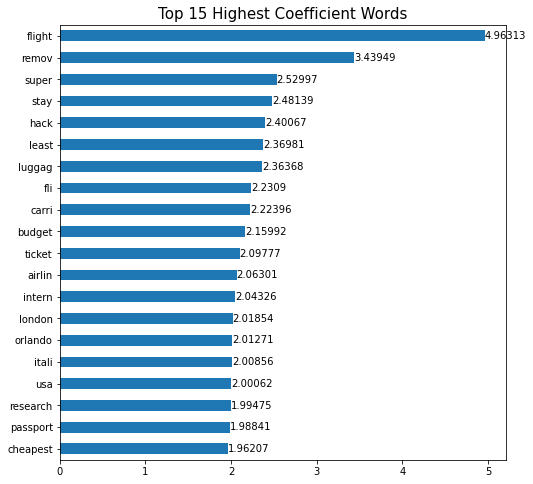

In [42]:
# plot top 20 recurring words that predict submissions is from TravelHacks reddit
plt.figure(figsize=(8, 8))
ax = logreg_base_coef.T[0].sort_values(ascending=True).tail(20).plot(kind='barh');
ax.bar_label(ax.containers[0]);
plt.title('Top 15 Highest Coefficient Words', size=15);

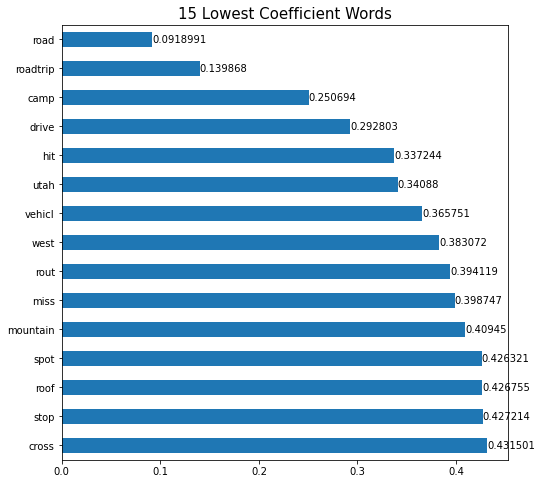

In [43]:
# plot top 15 recurring words that predict submissions is from roadtrip reddit
# lowest coefficient indicate highest preditability for roadtrip subreddit.
plt.figure(figsize=(8, 8))
ax = logreg_base_coef.T[0].sort_values(ascending=False).tail(15).plot(kind='barh');
ax.bar_label(ax.containers[0])
plt.title('15 Lowest Coefficient Words', size=15);

In [44]:
# 'remov' has a high coefficient. This may suggest that some removed submissions
# were not removed. This will be investigated further.
# convert X_train_data_features_cvec to Dataframe
X_train_data_features_cvec_df = pd.DataFrame(X_train_data_features_cvec.toarray(),
                                             columns=cvec.get_feature_names(),
                                             index=X_train.index)


C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
# Count number of entries containing 'remov'
X_train_data_features_cvec_df['remov'].value_counts()

0    2068
1      22
3       1
Name: remov, dtype: int64

In [46]:
# Get index of rows with the word 'remov'
remov_index = X_train_data_features_cvec_df[X_train_data_features_cvec_df['remov']>0].index
remov_index

Int64Index([2262, 2506,  732,  753,  485,  141,  128,  497,  886, 2223,  779,
            1760,   67,   99,  102,  370, 1286, 2222,  142,  876,  487,  185,
             110],
           dtype='int64')

In [47]:
# Display 'selftext_title' of rows in X_train containing 'remov'
# There are some posts that are supposed to be removed 
# but was not identified during data cleaning. 

combined_posts.loc[remov_index]['selftext_title']

2262    Dealing with a flat tire can be very inconveni...
2506    Hi, lately I have been looking into the idea o...
732     [removed]\n\n[View Poll](https://www.reddit.co...
753     [https://webcam-passport-photo.onrender.com](h...
485     [removed]\n\n[View Poll](https://www.reddit.co...
141     [removed]\n\n[View Poll](https://www.reddit.co...
128     [removed]\n\n[View Poll](https://www.reddit.co...
497     [removed]\n\n[View Poll](https://www.reddit.co...
886     [removed]\n\n[View Poll](https://www.reddit.co...
2223    We are hoping to do a bit more traveling this ...
779     1. 7-8/11 Rome\n    1. 8/7 Rome - ARRIVE\n    ...
1760    Hi Everyone, \n\nPre-pandemic, we could stop b...
67      [removed]\n\n[View Poll](https://www.reddit.co...
99      [removed]\n\n[View Poll](https://www.reddit.co...
102     [removed]\n\n[View Poll](https://www.reddit.co...
370     Getting back in the saddle for the first time ...
1286    [removed]\n\n[View Poll](https://www.reddit.co...
2222    I have

In [48]:
# 'rental' has one of the highest coefficient and this is not expected. 
# This may suggest that rental topics are better discussed in TravelHacks 
# instead of roadtrip subreddits. 
# This will be investigated further.
# Count number of entries containing 'rental'
X_train_data_features_cvec_df['rental'].value_counts()

0    1972
1      63
2      28
3      19
4       5
5       4
Name: rental, dtype: int64

In [49]:
# There are too many submissions with the word 'rental'
# It may not be possible to review through every single one. 
# To review submissions with more than 3 'rental' in submissions
# Get index of rows with the word 'rental'
rental_index = X_train_data_features_cvec_df[X_train_data_features_cvec_df['rental']>3].index
rental_index

Int64Index([1987, 2508, 1395, 1011, 404, 346, 1331, 887, 103], dtype='int64')

In [50]:
# Display 'selftext_title' of rows in X_train containing more than three 'rental'
# these submissions were related to car rental. 
combined_posts.loc[rental_index]['selftext_title']

1987    Hi! My first ever post on reddit (hopefully I ...
2508    I know the pandemic messed up the rental marke...
1395    Hey Reddit, I hope these tips find you well!\n...
1011    My partner and I are planning on spending a we...
404     I'm renting a car this August to drive out to ...
346     so i'm moving about \~6 hours away and want to...
1331    I got lucky last year when I booked a rental c...
887     Hi everyone! My wife and I just recently retur...
103     I do not own a car or have personal auto insur...
Name: selftext_title, dtype: object

#### Confusion Matrix

In [51]:
# Generate confusion matrix.
cm = confusion_matrix(y_test, y_pred_test)

# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

print(f'Confusion Matrix:\n{cm}\n')
print(f'tn: {tn}\n\
fp: {fp}\n\
fn: {fn}\n\
tp: {tp}\n')

Confusion Matrix:
[[214  26]
 [ 22 261]]

tn: 214
fp: 26
fn: 22
tp: 261



In [52]:
# Instantiate confusion matrix dataframe
cm_df = pd.DataFrame(cm, columns=['pred roadtrip', 'pred TravelHacks'], index=['actual roadtrip', 'actual TravelHacks'])
cm_df

,pred roadtrip,pred TravelHacks
actual roadtrip,214,26
actual TravelHacks,22,261


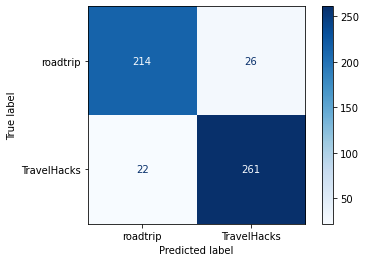

In [53]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['roadtrip', 'TravelHacks'])
disp.plot(cmap='Blues');

#### Receiver Operating Characteristic (ROC) Curve

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x432 with 0 Axes>

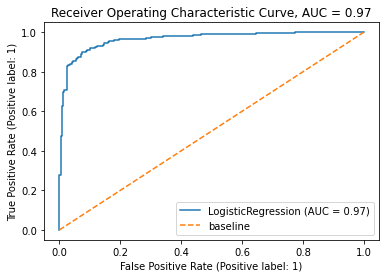

In [54]:
# ROC curve
plt.figure(figsize=(8, 6));
plot_roc_curve(logreg_base, X_test_data_features_cvec, y_test);

# Calculate ROC AUC.
roc_score = roc_auc_score(y_test, logreg.predict_proba(X_test_data_features_cvec)[:,1])

# add worst case scenario line
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--');

# add a legend
plt.legend();

# add plot title
plt.title(f'Receiver Operating Characteristic Curve, AUC = {round(roc_score, 2)}');


#### Scoring the Model
1. Scoring is based on accuracy. 
2. This is because, in this case, it is assessed that it is not critical if a submission was incorrectly mistaking a TravelHacks for a roadtrip post doesn't seem much better or worse than incorrectly mistaking a roadtrip for a TravelHacks post.
3. Hence, false positives and false negatives are assumed to have equal weightage and accuracy metric would be used for evaluation.

In [55]:
# Evaluate model on training data.
logreg_base.score(X_train_data_features_cvec, y_train)

0.9976087996174079

In [56]:
# Evaluate model on testing data.
logreg_base.score(X_test_data_features_cvec, y_test)

0.9082217973231358

In [57]:
# Compute cross_val_score on the X_train data set
cross_val_score(logreg_base, X_train_data_features_cvec, y_train, cv=5).mean()

0.9091434378961072

In [58]:
# Display proportion of Predicted TravelHacks to roadtrip subreddits.
print(f'y_test:\n{pd.DataFrame(y_pred_test).value_counts(normalize=True)}')

y_test:
1    0.548757
0    0.451243
dtype: float64


#### Top 10 Words with Highest Count in Train Data

In [59]:
# Display top 10 words with the highest count in train data. 
X_train_data_features_cvec_df.sum().sort_values(ascending=False).to_frame(name='frequency').head(10)

,frequency
travel,1253
day,1198
go,1041
would,1017
drive,928
plan,898
get,827
road,791
time,750
like,746


#### Model Evaluation
1. The accuracy of the training data and testing data are 99.8% and 90.8% respectively. The model performed better on training data set and is within expectation.
    - Since the baseline model has a higher accuracy on the training set than on the testing set, the model is overfit.
    - This overfitting could be address by removing features (e.g. setting max_features to be lower than 5000) and/or by regularizing our model.
2. The model has a cross validation accuracy of 90.9% on the train data. This means that the model is able to explain 90.9% of the variance in the y_train values.
3. The word 'remov' has a significantly high coefficient. There are 23 submissions with the word 'remov' in their 'selftext_title' column. Further analysis showed that submissions were labelled 'removed' but has some website in the self_text. Hence, it was not identified earlier in during data cleaning. These rows will be removed subsequently.

#### Removing rows that were labelled '[removed]'

In [60]:
# display rows with submissions '[removed]'
combined_posts[combined_posts['selftext'].str.contains('\[removed\]')]

,subreddit,author,selftext,title,created_utc,selftext_title,subreddit_label
67,TravelHacks,EconomicMetal,[removed]\n\n[View Poll](https://www.reddit.co...,Planning a surprise trip,2022-07-13 20:48:36,[removed]\n\n[View Poll](https://www.reddit.co...,1
99,TravelHacks,PitifulWorldliness,[removed]\n\n[View Poll](https://www.reddit.co...,Did inflation affect your vacation plans?,2022-07-11 15:50:56,[removed]\n\n[View Poll](https://www.reddit.co...,1
102,TravelHacks,Professional_Eye_987,[removed]\n\n[View Poll](https://www.reddit.co...,Beautiful road trip from Chandigarh to kasauli...,2022-07-11 13:00:31,[removed]\n\n[View Poll](https://www.reddit.co...,1
128,TravelHacks,Gadttravel2023,[removed]\n\n[View Poll](https://www.reddit.co...,Travel to Viet Nam,2022-07-08 03:30:13,[removed]\n\n[View Poll](https://www.reddit.co...,1
141,TravelHacks,SnooPandas5706,[removed]\n\n[View Poll](https://www.reddit.co...,What do you think of video-guided tour apps?,2022-07-07 12:47:27,[removed]\n\n[View Poll](https://www.reddit.co...,1
142,TravelHacks,SnooPandas5706,[removed]\n\n[View Poll](https://www.reddit.co...,What do you think of video-guided tour apps?,2022-07-07 12:42:53,[removed]\n\n[View Poll](https://www.reddit.co...,1
185,TravelHacks,Kshitij_More,[removed]\n\n[View Poll](https://www.reddit.co...,Will you like to post travel images in specifi...,2022-07-02 10:02:41,[removed]\n\n[View Poll](https://www.reddit.co...,1
413,TravelHacks,SelectLingonberry617,[removed]\n\n[View Poll](https://www.reddit.co...,"Undecided one-week solo trip, Chicago+LA? Indi...",2022-06-09 23:31:11,[removed]\n\n[View Poll](https://www.reddit.co...,1
485,TravelHacks,Fun_Pound_9099,[removed]\n\n[View Poll](https://www.reddit.co...,C&amp;E Travel Agency.,2022-06-02 15:41:26,[removed]\n\n[View Poll](https://www.reddit.co...,1
487,TravelHacks,Competitive-Panic473,[removed]\n\n[View Poll](https://www.reddit.co...,Your first choice?,2022-06-02 12:53:30,[removed]\n\n[View Poll](https://www.reddit.co...,1


In [61]:
# get index of rows with submissions '[removed]'
removed_index = combined_posts[
    combined_posts['selftext'].str.contains('\[removed\]')].index
removed_index

Int64Index([  67,   99,  102,  128,  141,  142,  185,  413,  485,  487,  497,
             692,  732,  876,  886,  943, 1286],
           dtype='int64')

In [62]:
# drop drows with submissions '[removed]' and reset index 
combined_posts.drop(index=removed_index, inplace=True)

In [63]:
# reset index for data set. 
combined_posts.reset_index(drop=True, inplace=True)

#### Redefine X, y and Train/Test Split

In [64]:
# re-define X and y. 
X = combined_posts[['selftext_title']]
y = combined_posts['subreddit_label']

In [65]:
# Re-create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify=y)

In [66]:
# Pre-process Training and Testing data set
X_train = sub_to_words(X_train)
X_test = sub_to_words(X_test)

# Convert X_train and X_test to series
X_train = X_train['selftext_title']
X_test = X_test['selftext_title']

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Wende.Joanne\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [67]:
# Instantiate count vectorizer object, which is sklearn's
# bag of words tool.
cvec = CountVectorizer()

# fit_transform() does two things: First, it fits the model and 
# learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a 
# list of strings.
X_train_data_features_cvec = cvec.fit_transform(X_train)
X_test_data_features_cvec = cvec.transform(X_test)


In [68]:
# create a LinearRegression model
logreg = LogisticRegression()

# fit it to training data 
logreg_base = logreg.fit(X_train_data_features_cvec, y_train)

In [69]:
# Evaluate model on training data.
logreg_base.score(X_train_data_features_cvec, y_train)

0.9971112181030333

In [70]:
# Evaluate model on testing data.
logreg_base.score(X_test_data_features_cvec, y_test)

0.9057692307692308

In [71]:
# Compute cross_val_score on the X_train data set
cross_val_score(logreg_base, X_train_data_features_cvec, y_train, cv=5).mean()

0.8984082483781279

#### Plot Results

##### Define plot_results Function

In [72]:
# define function to plot results. 
def plot_results(model, X_test, y_test):
    
    # Get predictions
    preds = model.predict(X_test)
    
    # Calculate test accuracy
    acc = accuracy_score(y_test, preds)

            
    #============= Plot Confusion Matrix =================    
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    cm = confusion_matrix(y_test, preds)

    # Calculate Sensitivity
    sens = tp / (tp + fn)
    
    # Calculate Specificity
    spec = tn / (tn + fp)
      
    # Instantiate confusion matrix dataframe
    cm_df = pd.DataFrame(cm, 
                         columns=['pred roadtrip', 'pred TravelHacks'], 
                         index=['actual roadtrip', 'actual TravelHacks'])

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=['roadtrip', 'TravelHacks'])
    disp.plot(cmap='Blues');
    
    
    
    #============= Plot ROC Curve =================
    # ROC curve
    plt.figure(figsize=(8, 6));
    plot_roc_curve(model, X_test, y_test);

    # Calculate ROC AUC.
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

    # add worst case scenario line
    plt.plot([0, 1], [0, 1],
             label='baseline', linestyle='--');

    # add a legend
    plt.legend();

    # add plot title 
    plt.title(f'Receiver Operating Characteristic Curve, AUC = {round(roc_score, 2)}');

    
    # Print results
    print(f'Accuracy: {accuracy_score(y_test, preds)}')
    print(f'Sensitivity: {sens}')
    print(f'Specificity: {spec}')
    print(f'ROC: {roc_score}\n')
    
    # Compile results in dataframe
    results = pd.DataFrame(data=[['',
                                  '',
                                  '',
                                  acc, 
                                  sens, 
                                  spec, 
                                  roc_score]],
                           columns=['Model',
                                    'Cross Validated Score',
                                    'Training Accuracy',
                                    'Accuracy', 
                                    'Sensitivity', 
                                    'Specificity', 
                                    'ROC'])    
    
    return results

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.9057692307692308
Sensitivity: 0.9283154121863799
Specificity: 0.8796680497925311
ROC: 0.9640238552030815



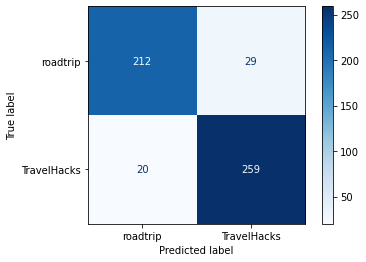

<Figure size 576x432 with 0 Axes>

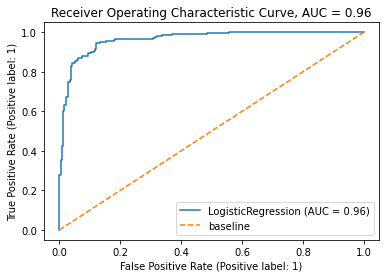

In [73]:
# Retrieve results of model
logreg_base_results = plot_results(logreg_base, 
                                   X_test_data_features_cvec, 
                                   y_test)

# Assigning value for model and training accuracy
logreg_base_results['Model'] = 'logreg_base'
logreg_base_results['Cross Validated Score'] = cross_val_score(
    logreg_base, 
    X_train_data_features_cvec, 
    y_train, 
    cv=5).mean()

logreg_base_results['Training Accuracy'] = logreg_base.score(
    X_train_data_features_cvec, 
    y_train
)

# Instantiate model summary dataframe.
model_summary = pd.DataFrame(logreg_base_results)


C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


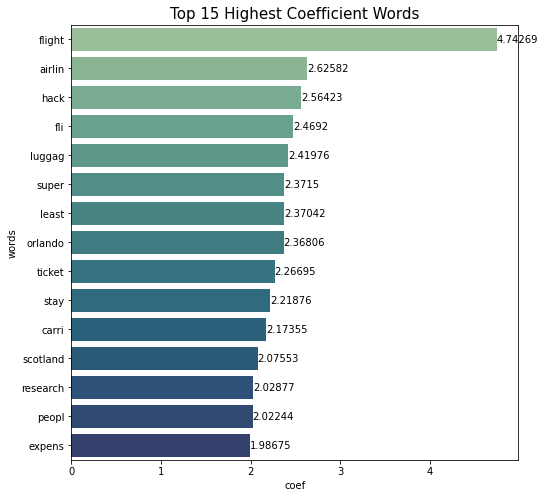

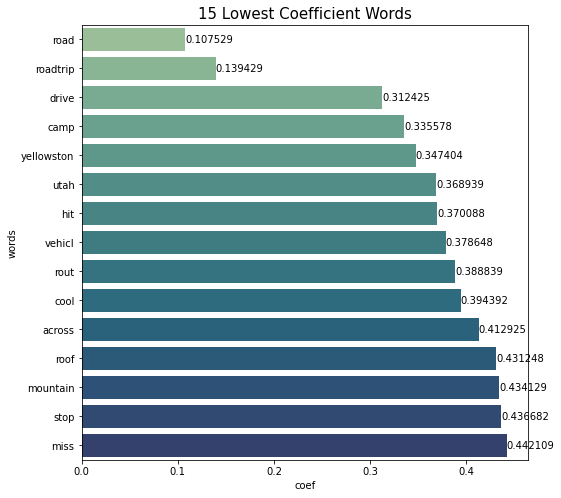

In [74]:
#============= Plot Coefficients Barplot =================
# retrieve words and corresponding coefficients
words = list(cvec.get_feature_names())
coef = list(np.exp(logreg_base.coef_[0]))

# Create dataframe with words and coef
coef_df = pd.DataFrame(zip(words, coef), columns=['words', 'coef'])

# set 'words' as index.
coef_df.set_index('words', inplace=True)


# plot top 15 recurring words that predict submissions is from TravelHacks reddit
plt.figure(figsize=(8, 8))
ax = sns.barplot(data=coef_df.sort_values(by='coef', ascending=False).head(15), 
                 y=coef_df.sort_values(by='coef', ascending=False).head(15).index, 
                 x='coef', 
                 palette="crest")
ax.bar_label(ax.containers[0])
plt.title('Top 15 Highest Coefficient Words', size=15);


# plot top 15 recurring words that predict submissions is from roadtrip reddit
# lowest coefficient indicate highest preditability for roadtrip subreddit.
plt.figure(figsize=(8, 8))
ax = sns.barplot(data=coef_df.sort_values(by='coef', ascending=True).head(15), 
                 y=coef_df.sort_values(by='coef', ascending=True).head(15).index, 
                 x='coef', 
                 palette="crest");
ax.bar_label(ax.containers[0])
plt.title('15 Lowest Coefficient Words', size=15);

#### Re-evaluation
1. The accuracy of the training data and testing data are 99.8% and 90.6% respectively. The model performed better on training data set and is within expectation.
    - Since the baseline model has a higher accuracy on the training set than on the testing set, the model is overfit.
    - This overfitting could be address by removing features (e.g. setting max_features to be lower than 5000) and/or by regularizing our model.
2. The model has a cross validation accuracy of 89.8% on the train data. This means that the model is able to explain 89.8% of the variance in the y_train values.
3. The Logistics Regression Base Model performed signicantly better than the baseline accuracy. 

### b. Logistic Regression Model with Cvec/Tvec

#### Define run_vect Function
The function aims to find out the best estimator.

In [75]:
def run_vect(estimator, X_train, y_train):

    # Let's set a pipeline up with two stages:
    # 1. count vectorizer (transformer)
    # 2. tf-idf vectorizer (transformer)
    # 3. logistic regression (estimator)
    cvec_pipe =  Pipeline([
        ('cvec', CountVectorizer()),
        ('estimator', estimator)
    ])

    tvec_pipe =  Pipeline([
        ('tvec', TfidfVectorizer()),
        ('estimator', estimator)
    ])

    # Search over the following values of hyperparameters:
    cvec_pipe_params = {
        'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
        'cvec__min_df': [2, 3, 4],
        'cvec__max_df': [0.85, 0.9, 0.95],
        'cvec__ngram_range': [(1,1), (1,2)]
    }

    tvec_pipe_params = {
        'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
        'tvec__min_df' : [2, 3, 4],
        'tvec__max_df': [0.85, 0.9, 0.95],
        'tvec__ngram_range': [(1,1), (1,2)],
    }

    # Instantiate GridSearchCV.
    gs_cvec = GridSearchCV(cvec_pipe,
                           param_grid=cvec_pipe_params, 
                           cv=5)

    gs_tvec = GridSearchCV(tvec_pipe,
                           param_grid=tvec_pipe_params, 
                           cv=5)

    # Fit GridSearch to training data.
    gs_cvec.fit(X_train, y_train);

    # Fit GridSearch to training data.
    gs_tvec.fit(X_train, y_train);
    
    
    # Find best score?
    print(f'Count Vectorizer scores: {gs_cvec.best_score_}')

    # Find best score?
    print(f'TF-IDF Vectorizer scores: {gs_tvec.best_score_}\n')
    
    if gs_cvec.best_score_>gs_tvec.best_score_:
        
        # print best vectorizer
        print('Best vectorizer: Count Vectorizer')
        
        # print best params
        print(f'Best parameters: {gs_cvec.best_params_}')
        
        # Score model on training set.
        print(f'Training Score: {gs_cvec.score(X_train, y_train)}')
              
        return gs_cvec.best_estimator_
    
    else:

        # print best vectorizer
        print('Best vectorizer: TF-IDF Vectorizer')
        
        # print best params
        print(f'Best parameters: \n{gs_tvec.best_params_}')
        
        # Score model on training set.
        print(f'Training Score: \n{gs_tvec.score(X_train, y_train)}')
       
        return gs_tvec.best_estimator_



#### Find Best Vectorizer

In [76]:
# find best vectorizer
gs_logreg_model = run_vect(LogisticRegression(), X_train, y_train)

Count Vectorizer scores: 0.9022532437442076
TF-IDF Vectorizer scores: 0.9162221964782207

Best vectorizer: TF-IDF Vectorizer
Best parameters: 
{'tvec__max_df': 0.85, 'tvec__max_features': 4000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
Training Score: 
0.9537794896485315


In [77]:
# Score model on testing set
gs_logreg_model.score(X_test, y_test)

0.9192307692307692

#### Plot gs_logreg_model Results

Accuracy: 0.9192307692307692
Sensitivity: 0.9354838709677419
Specificity: 0.9004149377593361
ROC: 0.9693630184862951



C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


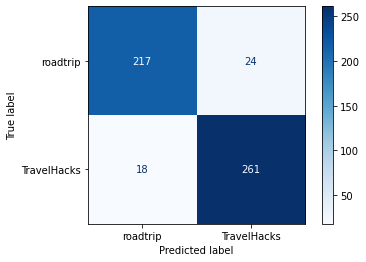

<Figure size 576x432 with 0 Axes>

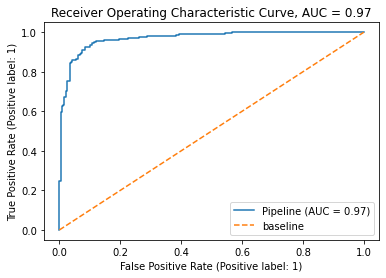

In [78]:
# plot results
gs_logreg_results = plot_results(gs_logreg_model, X_test, y_test)

In [79]:
# Assign value for model and training accuracy
gs_logreg_results['Model'] = 'logreg_tvec (gs_logreg_model)'
gs_logreg_results['Cross Validated Score'] = 0.922236617797477
gs_logreg_results['Training Accuracy'] = gs_logreg_model.score(X_train, y_train)
    
# append model results to model_summary dataframe
model_summary = pd.concat([model_summary, gs_logreg_results], ignore_index=True)

In [80]:
# Display models summary
model_summary

,Model,Cross Validated Score,Training Accuracy,Accuracy,Sensitivity,Specificity,ROC
0,logreg_base,0.898408,0.997111,0.905769,0.928315,0.879668,0.964024
1,logreg_tvec (gs_logreg_model),0.922237,0.953779,0.919231,0.935484,0.900415,0.969363


#### Model Evaluation
1. The accuracy of the training data and testing data are 95.4% and 91.9% respectively. The model performed better on training data set and is within expectation.
    - Since the model has a higher accuracy on the training set than on the testing set, the model is slightly overfit.
2. Comparing to the base logistics regression model, 
    - the logreg_tvec model is less fitted to the training data and achieve a slightly higher ROC score than the base model. 
    - This means that the logreg_tvec model performs slightly better in predicting the classifications.
    - This is because the model is able to reduce the number of false negatives(wrongly classify a TravelHacks submissions as roadtrip's) and false positives (wrongly classify a roadtrip submissions as TravelHacks') as seen from the better sensitivity score and specificity score.


#### Assessment on coefficients (see plots below)
1. There are a total of 4,000 features in the model, due to limit set. 
2. The highest coefficient of 73.4 correspond to the word 'flight'. This may be intepreted as an unit increase of the word 'flight' in the submission suggests that it is 73.4 times likely that the submissions is from TravelHacks subreddit,  holding all else constant. 
3. The lowest coefficient of 0.00175 corresponds to the word 'road'. This may be intepreted as an unit increase of the word 'road' in the submission suggests that it is 0.00175 times likely that the submissions is from TravelHacks subreddit,  holding all else constant.
4. It is interesting to note that main discussion in TravelHacks revolves around 'ticket', 'flight', 'airline'. This may suggest that travellers may prefer to find out about tips to get flying tips in TravelHacks. The project may consider reviewing strategies implemented by airlines at TravelHacks and partner airlines operating in Australia to attract travellers and increase availability of flight.

**TravelHacks**

5. The top five words for TravelHacks are 'flight', 'travel', 'book', 'ticket' and 'airline'.
6. It is interesting to note that main discussion in TravelHacks revolves around 'ticket', 'flight'. This may suggest that travellers may prefer to find out about tips to get cheap air tickets, travelling tips in TravelHacks. The project may consider reviewing strategies implemented by airlines at TravelHacks and partner airlines operating in Australia to attract travellers and increase availability of flight.
7. Other than the flight related topics under TravelHacks subreddit like air tickets discussed earlier, some of the interesting words identified here are:
    - 'test': travellers are concern with the types of test requirements (PCR, ART tests) during travelling. The project can explore providing testing services at airport to facilitate travellers meeting the requirements to ease the travellers' burden. 

**roadtrip**

8. The top five words that are not related to US states for roadtrip are 'road', 'drive', 'roadtrip', 'stop' and 'route'. 
9. Other words of interests to the project are 'camp', 'park', 'coast'.
10. This may suggest that discussion in roadtrip subreddit are concern about having stops and camping ground while travelling from one destination to another. Places of interests along the route includes parks and coastal roads. The project may consider establishing resting areas with amenities or camping areas around national parks or along coastal roads unique to Austrialia, e.g. the Great Ocean Road.  

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


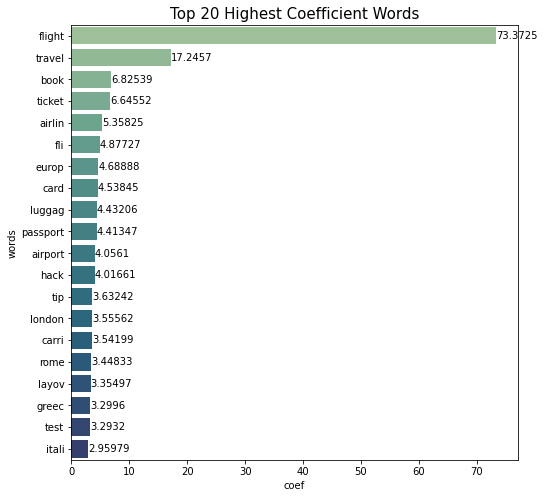

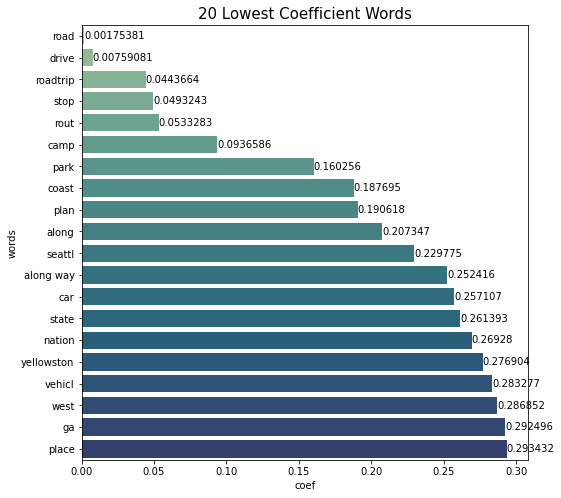

In [81]:
# Analysis of coefficients of model

#============= Plot Coefficients Barplot =================
# retrieve words and corresponding coefficients
words = list(gs_logreg_model.steps[0][1].get_feature_names())
coef = list(np.exp(gs_logreg_model.steps[1][1].coef_[0]))

# Create dataframe with words and coef
coef_df = pd.DataFrame(zip(words, coef), columns=['words', 'coef'])

# set 'words' as index.
coef_df.set_index('words', inplace=True)


# plot top 20 recurring words that predict submissions is from TravelHacks reddit
plt.figure(figsize=(8, 8))
ax = sns.barplot(data=coef_df.sort_values(by='coef', ascending=False).head(20), 
                 y=coef_df.sort_values(by='coef', ascending=False).head(20).index, 
                 x='coef', 
                 palette="crest")
ax.bar_label(ax.containers[0])
plt.title('Top 20 Highest Coefficient Words', size=15);


# plot top 20 recurring words that predict submissions is from roadtrip reddit
# lowest coefficient indicate highest preditability for roadtrip subreddit.
plt.figure(figsize=(8, 8))
ax = sns.barplot(data=coef_df.sort_values(by='coef', ascending=True).head(20), 
                 y=coef_df.sort_values(by='coef', ascending=True).head(20).index, 
                 x='coef', 
                 palette="crest");
ax.bar_label(ax.containers[0])
plt.title('20 Lowest Coefficient Words', size=15);

In [82]:
# Dataframe that links model's bag of words to X_train data 
# is to be created for further analysis.

# display set up for best estimator
gs_logreg_model

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=4000, min_df=3,
                                 ngram_range=(1, 2))),
                ('estimator', LogisticRegression())])

In [83]:
# Instantiate count vectorizer object, which is sklearn's
# bag of words tool.
gs_logreg_tvec = TfidfVectorizer(max_df=0.85, 
                                 max_features=4000, 
                                 min_df=3,
                                 ngram_range=(1, 2))

# fit_transform() does two things: First, it fits the model and 
# learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a 
# list of strings.
X_train_tvec = gs_logreg_tvec.fit_transform(X_train)

In [84]:
# convert X_train_cvec to Dataframe for further analysis
X_train_features_df = pd.DataFrame(X_train_tvec.toarray(),
                                   columns=gs_logreg_tvec.get_feature_names(),
                                   index=X_train.index)

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [85]:
# Explore content which has 'test' word
test_index=X_train_features_df[X_train_features_df['test']>0].index
len(test_index), list(test_index)

(31,
 [1024,
  1183,
  1251,
  1212,
  1057,
  996,
  1094,
  495,
  1102,
  764,
  1090,
  235,
  705,
  580,
  1064,
  707,
  802,
  183,
  553,
  1220,
  67,
  1126,
  2153,
  436,
  591,
  945,
  841,
  1082,
  515,
  1284,
  785])

In [86]:
# print out 5 rows of content that has word 'test' 
for i in test_index[:5]:
    text = combined_posts['selftext_title'].loc[i]
    print(f'Index {i}:\n{text}\n\n')

Index 1024:
Hi. I've never been to Hawaii and am seeking advice. Single older guy looking to take girlfriend. 

Here's my questions:
- best island for white sandy beaches and warm blue water
- best all inclusive package on that island
- has adults only pools and jacuzzi
- and less crowded beaches
- best time of year to go
- is proof of vaccination or negative test required for the flights or to enter the state? 

Anything I'm forgetting? 

Thank you. Hawaii


Index 1183:
Hello! A friend and I are travelling to Morocco next Monday and I’m wondering if anyone has some light to shed on the vague language used to describe the PCR test window within the Moroccan travel requirements.
  
Our itinerary is to fly within Canada to a larger airport, then to Paris, and finally to Casablanca. The total trip will take about 18 hours. For the PCR tests available to us, the turn around time for results is 24-48 hours.
  
Does the 48 hour window for negative PCR tests apply to our first leg of the trip

### c. Naive-Bayes Model with Cvec/Tvec

#### Find Best Vectorizer
1. MultinomialNB is chosen because the columns of X are all integer counts. 

In [87]:
# find best vectorizer
gs_nb_model = run_vect(MultinomialNB(), X_train, y_train)

Count Vectorizer scores: 0.9061132993512512
TF-IDF Vectorizer scores: 0.905633688600556

Best vectorizer: Count Vectorizer
Best parameters: {'cvec__max_df': 0.85, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Training Score: 0.9325950890707752


In [88]:
# Score model on testing set
gs_nb_model.score(X_test, y_test)

0.8980769230769231

#### Plot gs_nb_model Results

Accuracy: 0.8980769230769231
Sensitivity: 0.8709677419354839
Specificity: 0.9294605809128631
ROC: 0.9599042222519669



C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


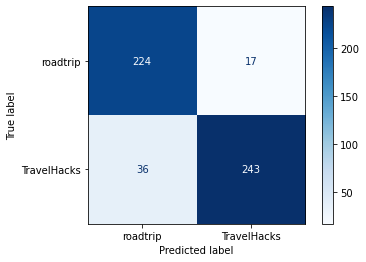

<Figure size 576x432 with 0 Axes>

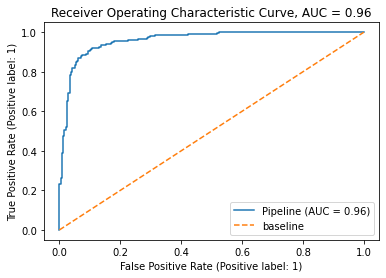

In [89]:
gs_nb_results = plot_results(gs_nb_model, X_test, y_test)

In [90]:
# Assign value for model and training accuracy
gs_nb_results['Model'] = 'nb_cvec (gs_nb_model)'
gs_nb_results['Cross Validated Score'] = 0.9325950890707752
gs_nb_results['Training Accuracy'] = gs_nb_model.score(X_train, y_train)

# append model results to model_summary dataframe
model_summary = pd.concat([model_summary, gs_nb_results], ignore_index=True)

In [91]:
# Display models summary
model_summary

,Model,Cross Validated Score,Training Accuracy,Accuracy,Sensitivity,Specificity,ROC
0,logreg_base,0.898408,0.997111,0.905769,0.928315,0.879668,0.964024
1,logreg_tvec (gs_logreg_model),0.922237,0.953779,0.919231,0.935484,0.900415,0.969363
2,nb_cvec (gs_nb_model),0.932595,0.932595,0.898077,0.870968,0.929461,0.959904


#### Model Evaluation
1. For the Naive Bayes Model with count vectorizer, the accuracy of the training data and testing data are 93.3% and 89.8% respectively. The model performed better on training data set and is within expectation.
    - Since the model has a higher accuracy on the training set than on the testing set, the model is slightly overfit.
2. Comparing to the base logistics regression model, 
    - While the nb_cvec model is less fitted to the training data, it achieved a slightly lower ROC score than the base model as it has higher number of false positives (lower sensitivity).
    - This means that the nb_cvec model model performs slightly worse in predicting the classifications than the base model.
    - This may be because the model assumes that the features are independent of each other.


#### Assessment on Important Features (see plots below)
1. There are a total of 3,000 features in the model, due to the limit set. 

**TravelHacks**

2. The top five words of importance to classify submission as TravelHacks are 'layover', 'hack', 'airline', 'refund' and 'discount'.
3. Similar to earlier observations, the main discussion in TravelHacks revolves around 'flight'. This may suggest that travellers may prefer to find out about tips to get cheap air tickets, travelling tips in TravelHacks. The project may consider reviewing strategies implemented by airlines at TravelHacks and partner airlines operating in Australia to attract travellers and increase availability of flight.
4. Other than the flight related topics under TravelHacks subreddit like air tickets discussed earlier, 'test' is also part of the top 20 words. In addition one other interesting word identified is:
    - 'test': travellers are concern with the types of test requirements (PCR, ART tests) during travelling. The project can explore providing testing services at airport to facilitate travellers meeting the requirements to ease the travellers' burden. 
    - 'vaccine': travellers are concerned about being vaccinated or show proof of vaccine when travelling to other countries. As vaccination is up to individuals. There is not much Australia can do about it. However, resources may be invested in countries where vaccination take up rate is high, for example, Singapore. 

**roadtrip**

5. The top five words of importance that are not related to US states to classify submission as roadtrip are 'np', 'rv', 'roadtrip', 'campground' and 'detour'.
    - 'np' refers National Park, from the analysis. This suggests that travellers are interested in travelling to national park as part of their roadtrips.
    - 'rv' refers to recreational vehicles. This suggests that travellers are concern about comfort of being in the recreational vehicles for long trips. Having stops in between may help. The project can also partner car rental agency to supply more SUVs or campervans for better comfort, especially for families.  
    - 'detour': In general, minor detours are acceptable to travellers. Attractions that are slightly off typical roadtrip route may be promoted for travellers to have an unique Australian experience.   
    - 'yellowstone', 'zion', 'yosemite', 'arches' are national parks in US. 
    - 'moab' is a city in US.
    - 'utah' is a state in US.
6. It is interesting to note that camp related words occur several times in the top 20 words: 'campground', 'camper', 'camp' and 'campsit'. This suggest that travellers are interested in camping while on roadtrip. 


In [92]:
# Computing the prob for each class
log_prob_diff = np.round((gs_nb_model.steps[1][1].feature_log_prob_[1] 
                          - gs_nb_model.steps[1][1].feature_log_prob_[0]), 2)



In [93]:
# Compile log_prob_diff into a dataframe
log_prob_df = pd.DataFrame(log_prob_diff, 
                           index=gs_nb_model[0].get_feature_names_out(), 
                           columns=['log_prob_diff'])
log_prob_df['P(word|TravelHacks) Log Prob'] = np.exp(gs_nb_model.steps[1][1].feature_log_prob_[1])
log_prob_df['P(word|roadtrip) Log Prob'] = np.exp(gs_nb_model.steps[1][1].feature_log_prob_[0])

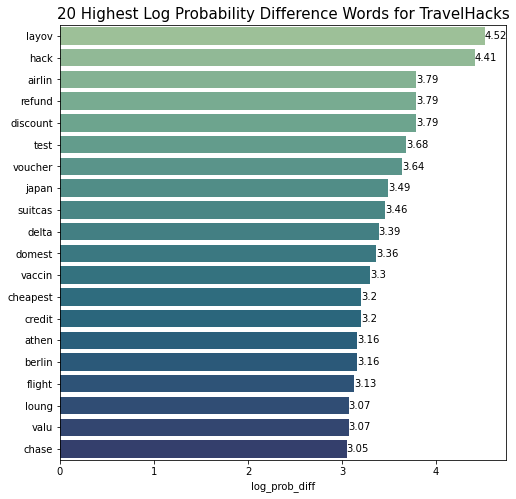

In [94]:
# plot top 20 words that differentiate TravelHacks submissions from roadtrip's
plt.figure(figsize=(8, 8))
ax = sns.barplot(data=log_prob_df.sort_values(by='log_prob_diff', ascending=False).head(20), 
                 y=log_prob_df.sort_values(by='log_prob_diff', ascending=False).head(20).index, 
                 x='log_prob_diff', 
                 palette="crest");
ax.bar_label(ax.containers[0])
plt.title('20 Highest Log Probability Difference Words for TravelHacks', size=15);

In [95]:
# Dataframe that links model's bag of words to X_train data 
# is to be created for further analysis.

# display set up for best estimator
gs_nb_model

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.85, max_features=3000, min_df=2)),
                ('estimator', MultinomialNB())])

In [96]:
# Instantiate count vectorizer object, which is sklearn's
# bag of words tool.
gs_nb_cvec = CountVectorizer(max_df=0.85, 
                                 max_features=3000, 
                                 min_df=2)

# fit_transform() does two things: First, it fits the model and 
# learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a 
# list of strings.
X_train_cvec = gs_nb_cvec.fit_transform(X_train)

In [97]:
# convert X_train_cvec to Dataframe for further analysis
X_train_features_df = pd.DataFrame(X_train_cvec.toarray(),
                                   columns=gs_nb_cvec.get_feature_names(),
                                   index=X_train.index)

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [98]:
# Explore content which has 'vaccin' word
vaccin_index=X_train_features_df[X_train_features_df['vaccin']>0].index
len(vaccin_index), list(vaccin_index)

(26,
 [1024,
  1291,
  821,
  1191,
  911,
  764,
  922,
  1090,
  891,
  892,
  1298,
  1264,
  1380,
  29,
  67,
  1126,
  368,
  627,
  1320,
  787,
  591,
  945,
  1082,
  1284,
  1828,
  785])

In [99]:
# print out 5 rows of content that has word 'np'
for i in vaccin_index[:5]:
    text = combined_posts['selftext_title'].loc[i]
    print(f'Index {i}:\n{text}\n\n')

Index 1024:
Hi. I've never been to Hawaii and am seeking advice. Single older guy looking to take girlfriend. 

Here's my questions:
- best island for white sandy beaches and warm blue water
- best all inclusive package on that island
- has adults only pools and jacuzzi
- and less crowded beaches
- best time of year to go
- is proof of vaccination or negative test required for the flights or to enter the state? 

Anything I'm forgetting? 

Thank you. Hawaii


Index 1291:
Traveling to Germany from USA and I only have a paper vaccine card. From what I can tell, I need an electronic QR code proof of vaccination. How do I get that? I’ve noticed that not only do I need proof to get in the country, I need it to get into attractions like castles. I want to make sure I get this squared away before we leave in a few months. Thanks! Proof of vaccination accepted in Germany, Austria, and Switzerland


Index 821:
I have a vaccine card from USA. Its getting brown/dirty. I'm trying to figure out whi

1. The higher the difference in the log probability of the word, the higher is its importance in classifying a submission as TravelHacks subreddit.
2. The top five words of importance to classify submission as TravelHacks are 'layover', 'hack', 'airline', 'refund' and 'discount'.
3. Other than the flight related topics under TravelHacks subreddit like air tickets discussed earlier, some of the interesting words identified here are:
    - 'test': travellers are concern with the types of test requirements (PCR, ART tests) during travelling. The project can explore providing testing services at airport to facilitate travellers meeting the requirements to ease the travellers' burden. 
    - 'vaccine': travellers are concerned about being vaccinated or show proof of vaccine when travelling to other countries. 

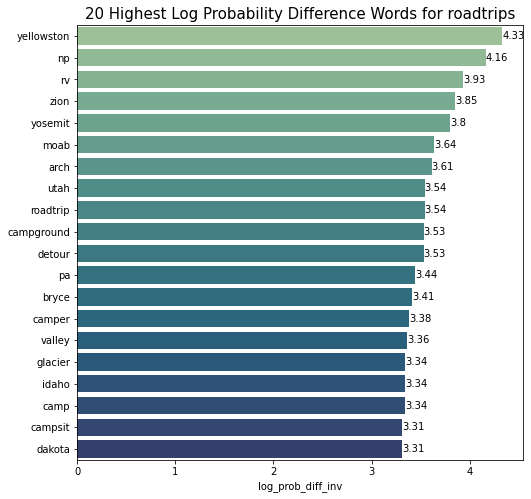

In [100]:
# Compute log_prob_diff for roadtrip
log_prob_df['log_prob_diff_inv'] = log_prob_df['log_prob_diff'].map(lambda value: -1*value)

# plot top 20 words that differentiate TravelHacks submissions from roadtrip's
plt.figure(figsize=(8, 8))
ax = sns.barplot(data=log_prob_df.sort_values(by='log_prob_diff_inv', 
                                              ascending=False).head(20), 
                 y=log_prob_df.sort_values(by='log_prob_diff_inv', 
                                           ascending=False).head(20).index, 
                 x='log_prob_diff_inv', 
                 palette="crest");
ax.bar_label(ax.containers[0])
plt.title('20 Highest Log Probability Difference Words for roadtrips', size=15);

In [101]:
# Explore content which has 'np' word
np_index=X_train_features_df[X_train_features_df['np']>0].index
len(np_index), list(np_index)

(22,
 [1623,
  2301,
  1833,
  2113,
  2532,
  1707,
  2582,
  2123,
  1574,
  2535,
  1693,
  2122,
  1626,
  1500,
  1591,
  2452,
  1988,
  1999,
  2336,
  2203,
  1843,
  2304])

In [102]:
# print out 5 rows of content that has word 'np'
for i in np_index[:5]:
    text = combined_posts['selftext_title'].loc[i]
    print(f'Index {i}:\n{text}\n\n')

Index 1623:
Hello! My SO and I want to take our Australian Shepherd on his first roadtrip from 8/27-9/5 and know that we want to camp in Acadia NP, but are not sure what would be the best route to drive out there? I haven’t seen the east coast at all so ideally we’d get to see some of that on our way out or on the way back to Cleveland. 


The route options I’ve come up with are the following:


1.	(15ish hrs) Cle > Buffalo NY > Syracuse NY > Albany NY > Boston MA > Portland ME > Acadia 
2.	(15ish hrs) Cle > drive through mid PA (stop in Scranton-ish area?) > Hartford CT > Boston MA > Portland ME > Acadia
3.	(17ish hrs) Cle > Pittsburgh > Philadelphia > Hartford CT > Boston MA > Portland ME > Acadia 


I think #3 might be cool because I know someone in Philly and I’ve never been, though it’s definitely the longer route. 


I’ve never road-tripped with a dog before either so I’m not sure how often we’ll want to stop or where to stay along the route (probably motels until we get to Maine

In [103]:
# Explore content which has 'rv' word
rv_index=X_train_features_df[X_train_features_df['rv']>0].index
len(rv_index), list(rv_index)

(23,
 [2455,
  1593,
  1970,
  1503,
  2113,
  2453,
  2030,
  2540,
  2109,
  2321,
  1574,
  2302,
  2129,
  2543,
  2020,
  2017,
  1631,
  2023,
  2118,
  2111,
  2353,
  1894,
  1748])

In [104]:
# print out 5 rows of content that has word 'rv'
for i in rv_index[:5]:
    text = combined_posts['selftext_title'].loc[i]
    print(f'Index {i}:\n{text}\n\n')

Index 2455:
My family and I are from Hawaii and we'll be spending 15 days in the states in March. We plan to take an RV from Los Angeles to Washington DC and back mostly to get a taste of areas we'd like to spend more time in for future trips. We've been up and down the East and West Coasts but never went cross country.

Below is the route we're planning to take. We can't extend the trip, but what recommendations do you have on:

1. Quick stops along the route should definitely not miss or 
2. Changes in the route that are worth making
3. RV tips (we're very worried about snow and hail, should we be?)

Our son is off to college later this year so it'll be good to spend a good chunk of time together with him and our daughters. We're excited to venture out from the islands yet again :)

https://preview.redd.it/30gewvebqwi81.png?width=668&format=png&auto=webp&s=fd4689a128c1a0b18b9aff77a11a5e963a3ee13a Los Angeles to Washington DC and back in 15 days with a family of 5...what's the best ro

In [105]:
# Explore content which has 'arch' word
arch_index=X_train_features_df[X_train_features_df['arch']>0].index
len(arch_index), list(arch_index)

(26,
 [2301,
  2177,
  2262,
  2345,
  1451,
  2260,
  1487,
  2533,
  2380,
  2453,
  2167,
  2540,
  1707,
  2187,
  1598,
  1723,
  2392,
  2004,
  1770,
  1988,
  2023,
  2203,
  1547,
  2077,
  2304,
  2501])

In [106]:
# print out 5 rows of content that has word 'arch'
for i in arch_index[:5]:
    text = combined_posts['selftext_title'].loc[i]
    print(f'Index {i}:\n{text}\n\n')

Index 2301:
I'm moving to San Diego, CA for work and considering a road trip with my family from Chicago, IL to San Diego, CA. I'll have my parents with me (both of them are in their 50s). The point is to cover the tourist spots on the way, and I'd ideally like to keep the trip under 25 days. I have thought about two possible options: 

1. Chicago > Yellowstone NP > Arches NP > Grand Canyon NP > Las Vegas > SD
2. Chicago > Rocky Mountain NP > Arches NP > Grand Canyon NP > Las Vegas > SD

​

[Route plan for Option 1](https://preview.redd.it/53kk4naj69o81.png?width=2312&format=png&auto=webp&s=3c81c413f16af61f2c60e3c221895dcb57c1aa01)

​

[Route plan for Option 2](https://preview.redd.it/z1zpurom69o81.png?width=2258&format=png&auto=webp&s=8d0d9e4638ce4734828159ffd9256b61d24e8eed) Road-tripping with family from Chicago to San Diego. Looking to cover tourist spots on the way. Route suggestions?


Index 2177:
We got ticket entrance to Arches National Park at 1pm. 

Please suggest some places

In [107]:
# Explore content which has 'detour' word
detour_index=X_train_features_df[X_train_features_df['detour']>0].index
len(detour_index), list(detour_index)

(29,
 [1471,
  2449,
  1568,
  2494,
  2010,
  1967,
  1401,
  1551,
  2532,
  2361,
  2369,
  2593,
  1422,
  1872,
  2012,
  1827,
  1855,
  1697,
  1607,
  2015,
  2458,
  2201,
  2528,
  1881,
  1965,
  1896,
  1753,
  1791,
  2501])

In [108]:
# print out 5 rows of content that has word 'detour'
for i in detour_index[:5]:
    text = combined_posts['selftext_title'].loc[i]
    print(f'Index {i}:\n{text}\n\n')

Index 1471:
Hello everyone. I'm planning a trip starting in Zurich - Milan - Genoa - Monaco - Marseille - Grenoble - Geneva - Zurich. The trip will be in April 2023. The itinerary is flexible. 

What do I need to know? 
What do I need to prepare for border crossings?
Do I actually need an international driving permit?
Any suggested detours? Things to do it not to do? 
Any help or thoughts will be appreciated. Planning a road trip in Europe as an American


Index 2449:
Hello, people. I am thinking about travelling all over the US on a sightseeing tour looking for my new home and plan to camp in some national parks/forests to help cut down on costs along the way. Maybe camp for 1/3 or 1/4 of the time in various places.

The states I am looking to travel to and see are, Nevada, California, Oregon, Washington, Montana, Wyoming, South Dakota, Colorado, Oklahoma, Illinois, Indiana, West Virginia, Virginia and D.C. and am willing to make plenty of detours as well.

Do you guys have any sugges

### Overview of all models

In [109]:
# Display models summary
model_summary

,Model,Cross Validated Score,Training Accuracy,Accuracy,Sensitivity,Specificity,ROC
0,logreg_base,0.898408,0.997111,0.905769,0.928315,0.879668,0.964024
1,logreg_tvec (gs_logreg_model),0.922237,0.953779,0.919231,0.935484,0.900415,0.969363
2,nb_cvec (gs_nb_model),0.932595,0.932595,0.898077,0.870968,0.929461,0.959904


### Evaluation

1. Of all the models created, logreg_tvec (Logistics Regression Model with tf-idf vectorizer) performed the best based on the highest Test Accuracy score and ROC score of 92% and 97% respectively. This is a significant improvement from the Zero Rate Classifier (baseline accuracy), with a of an improvement about 40% increase (80% increase).
2. The difference between the testing and training accuracy is small, about 3%.
3. The model has a Training Cross Validation accuracy score of 92%. This means the model is able to explain 92% of the variance in the y_train values.
4. The top 5 important features use to classify the respective subreddits are shown in the table below. This means that the probability of a submission classifying in the respective subreddit increase with the increase of the number of words in each group.

|TravelHacks|roadtrip|
|-|-|
|flight|road|
|travel|drive|
|book|roadtrip|
|ticket|stop|
|airline|route|

5. The improvement in accuracy of the model is likely due to the reduction number of features (from the original 7044 features to 3000) used to train the model, reducing overfitting and resulting in lower biasness and higher variance.


#### Misclassified Submissions
- The following section aims to analyse the reason for misclassifications. 
- Refer to the confusion matrix [here](#Plot-gs_logreg_model-Results).

In [110]:
# Display parameters for Logistics Regression Model with tf-idf vectorizer 
gs_logreg_model

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=4000, min_df=3,
                                 ngram_range=(1, 2))),
                ('estimator', LogisticRegression())])

In [111]:
# Instantiate count vectorizer object, which is sklearn's
# bag of words tool.
gs_logreg_tvec = TfidfVectorizer(max_df=0.85, 
                                 max_features=4000, 
                                 min_df=3,
                                 ngram_range=(1, 2))

# fit_transform() does two things: First, it fits the model and 
# learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a 
# list of strings, which will be used to transform X_test. 
X_train_tvec = gs_logreg_tvec.fit_transform(X_train)
X_test_tvec = gs_logreg_tvec.transform(X_test)

In [112]:
# Re-instantiate Dataframe for further analysis
X_test_features_df = pd.DataFrame(X_test_tvec.toarray(),
                                   columns=gs_logreg_tvec.get_feature_names(),
                                   index=X_test.index)

C:\Users\Wende.Joanne\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [113]:
# Comparing predictions from Logistics Regression Model with tf-idf vectorizer 
# against y_test data
y_preds = gs_logreg_model.predict(X_test)

In [114]:
# convert y_preds to dataframe
true_pred_df = y_test.to_frame()#.merge(y_preds)
true_pred_df['y_preds'] = y_preds
true_pred_df.head()

,subreddit_label,y_preds
837,1,1
97,1,1
701,1,1
493,1,1
822,1,1


In [115]:
# Retrieve probability for X_test.
proba_df=pd.DataFrame(gs_logreg_model.predict_proba(X_test), 
             index=X_test.index)

proba_df.head()

,0,1
837,0.314561,0.685439
97,0.256032,0.743968
701,0.156290,0.843710
493,0.497697,0.502303
822,0.102825,0.897175


##### False Positives (predict a roadtrip submission as TravelHacks submission)
1. The probability of these post being in TravelHacks ranges between 50% and 70%, for most of the submissions. This means that they are borderline cases where they could be in either subreddits.
2. These submissions are wrongly classified likely due to the inclusion of key words in TravelHacks such as 'travel' and 'book'
3. They also contain words that are common to both subreddits, such as 'plan', which are ambiguous in predicting the submissions. 
4. These submissions may either be irrelevant to the subreddit (e.g. advertisements/spams) or do not have enough content for the model to better classify it. 

In [116]:
# Retrieve false positives 
# (predict a roadtrip submission as TravelHacks submission)
false_positive_index = true_pred_df[
    (true_pred_df['y_preds'] == 1) 
    & (true_pred_df['subreddit_label'] == 0)
].index

In [117]:
# verify probability of these subsmissions
proba_df.loc[false_positive_index]

,0,1
2093,0.341215,0.658785
2104,0.464449,0.535551
2433,0.260511,0.739489
2120,0.373335,0.626665
2235,0.361153,0.638847
2416,0.372353,0.627647
1625,0.219714,0.780286
2137,0.117313,0.882687
2027,0.489784,0.510216
1904,0.228528,0.771472


In [118]:
# retrieve words count in these submissions. 
words=[]

for i in false_positive_index:
    words.extend(X_test_features_df.columns[(X_test_features_df.loc[i] != 0)])
    
words_dict = {i:words.count(i) for i in words}
        
words_dict_df = pd.DataFrame(words_dict.items(), 
                             columns= ['word', 'count'])

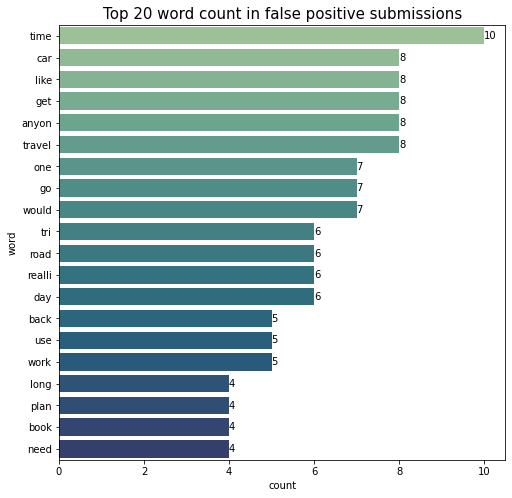

In [119]:
# plot word count
plt.figure(figsize=(8, 8))
ax = sns.barplot(data=words_dict_df.sort_values(by='count', 
                                                 ascending=False).head(20), 
                 y=words_dict_df.sort_values(by='count', 
                                             ascending=False).head(20)['word'], 
                 x='count', 
                 palette="crest");
ax.bar_label(ax.containers[0])
plt.title('Top 20 word count in false positive submissions', size=15);

In [120]:
# display context of these submissions. 
for i in false_positive_index[:3]:
    content = combined_posts.loc[i]['selftext_title']
    print(f'Index {i}:\n{content}\n\n')

Index 2093:
Hi! Join the Bitcoin 19 millionth Airdrop on LATOKEN for a chance to win 💲500 (and additional rewards for first time traders/depositors)
https://latoken.com/airdrops/entrance?refcode=hm2r6wpx&airdrop=BTC&source=sbre LATOKEN BTC Airdrop


Index 2104:
I’m on a car trip for my grandpa’s funeral and my ass is now numb. I can feel that I cant feel my butt. But it’s numb. Is this normal? My ass is numb


Index 2433:
Anybody have any tips for staying warm while traveling/ living in my car. It's average 25 - 35° right now in my area Staying warm




##### False Negatives (predict a TravelHacks submission as roadtrip submission)
1. The probability of these post being in roadtrip ranges between 50% and 70%, for most of the submissions. This means that they are borderline cases where they could be in either subreddits.
2. These submissions are wrongly classified likely due to the inclusion words that are common to both subreddits, such as 'plan', which are ambiguous in predicting the submissions. 
3. These submissions may either contain images & links or do not have enough content for the model to better classify it.

In [121]:
# Retrieve false positives 
# (predict a roadtrip submission as TravelHacks submission)
false_negative_index = true_pred_df[
    (true_pred_df['y_preds'] == 0) 
    & (true_pred_df['subreddit_label'] == 1)
].index

In [122]:
# verify probability of these subsmissions
proba_df.loc[false_negative_index]

,0,1
1062,0.509699,0.490301
182,0.540646,0.459354
1308,0.622027,0.377973
375,0.822653,0.177347
1130,0.690649,0.309351
523,0.765480,0.234520
1085,0.651514,0.348486
153,0.505605,0.494395
1179,0.845811,0.154189
774,0.511454,0.488546


In [123]:
# retrieve words count in these submissions. 
words=[]

for i in false_negative_index:
    words.extend(X_test_features_df.columns[(X_test_features_df.loc[i] != 0)])
    
words_dict = {i:words.count(i) for i in words}
        
words_dict_df = pd.DataFrame(words_dict.items(), 
                             columns= ['word', 'count'])

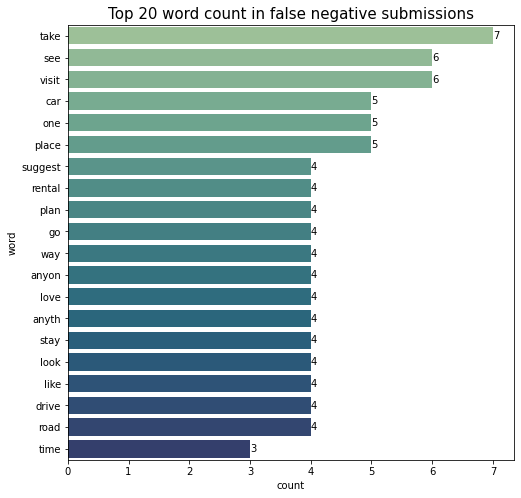

In [124]:
# plot word count
plt.figure(figsize=(8, 8))
ax = sns.barplot(data=words_dict_df.sort_values(by='count', 
                                                 ascending=False).head(20), 
                 y=words_dict_df.sort_values(by='count', 
                                             ascending=False).head(20)['word'], 
                 x='count', 
                 palette="crest");
ax.bar_label(ax.containers[0])
plt.title('Top 20 word count in false negative submissions', size=15);

In [125]:
# display context of these submissions. 
for i in false_negative_index[:5]:
    content = combined_posts.loc[i]['selftext_title']
    print(f'Index {i}:\n{content}\n\n')

Index 1062:
There are many amazing places to visit in Stockholm, Sweden. 

Some of the most popular tourist destinations include the Royal Palace, the Vasa Museum, and Skansen.

[Here](https://semlas.com/blog/2022/03/10/looking-for-the-best-places-to-visit-in-stockholm/) is the list of the best places to visit in Stockholm. The Best Places to visit in Stockholm, Sweden


Index 182:
https://i.imgur.com/9eHmJEZ.jpg Any idea where this could be?


Index 1308:
I surprised my gf w tickets to a concert in New York for our one year anniversary. I’ve never been to New York but she loves it. I am not a huge fan of the fast paced chaotic life and tbh the crime out there scares me a little. I would love to take her to some cool local spots instead of doing the hype over populated touristy spots. We love art, live music, whole in the walls, good views, good food and nature. We will be staying Friday-Monday around Brooklyn, as that’s where the concert will be. I am open to suggestions! Any New York

---
## 4. Recommendations and Future Works

### Proposed Classification Model: Logistics Regression Model with TF-IDF vectorizer (logreg_tvec)

1. The project proposed the adoption of Logistics Regression Model with TF-IDF vectorizer (logreg_tvec) to the Senior Management Team of the agency.
2. The model has highest test Accuracy score and ROC score of 95% and 97% respectively.
3. The model has a Training Cross Validation accuracy score of 92%. This means the model is able to explain 92% of the variance in the subreddit classifications.
4. It is recommended that logreg_tvec (Logistics Regression Model with tf-idf vectorizer) is the best classification model of all the models and will be proposed to the senior management to deploy online for travellers to use. 

### Proposals to Attract Travellers based on respective Subreddits. 
(based on assessment of coefficients/importance of features and sentiment analysis)

**Findings from TravelHacks**
1. Flight Deals and Availability:
    - The project may consider reviewing strategies implemented by airlines at TravelHacks and partner airlines operating in Australia to attract travellers and increase availability of flight.
2. Car Rental Cost and Trustworthiness:
    - The project could consider attracting more car rental companies to operate at the airport to provide more economical solutions (increase supply will lower costs). Grading systems for car rental companies would be beneficial for traveller to make better informed decisions and partner with a more trustworthy rental company.
3. Covid Testing:
    - The project can explore formulating policy to support travellers who are tested positively to recoup some of the costs incurred during planning or to delay their trip. 
    -  The project can explore providing testing services at airport to facilitate travellers meeting the requirements to ease the travellers' burden.
4. Vaccination Status:
    - travellers are concerned about being vaccinated or show proof of vaccine when travelling to other countries. As vaccination is up to individuals. There is not much Australia can do about it. However, marketing resources may be invested in countries where vaccination take up rate is high, for example, Singapore.
5. Travel Insurance:
    - Given the uncertainty of the evolving Covid measures, it is important that travel insurance covers the unfortunate event that a traveller being infected by Covid. The project can consider partnering travel insurance agency to provide such coverage for this event.

**Findings from roadtrip**
1. Safety:
    - The project may review the typical routes for road trips in Australia to pass through areas that are safer. Police stations could be situated at intervals along the typical routes to assure travellers or assist travellers if needed.
2. Stops/detours:
    - The project may considor building attractions or amenities pit stop along typical scenic route in Australia so that travellers could take breaks in between long drives.
    - The project may consider establishing resting areas with amenities or camping areas around nature parks or along coastal roads unique to Austrialia, e.g. the Great Ocean Road.
3. Attractions:
    - Places of interests along the route to include nature parks and coastal roads. 
4. Vehicle Types:
    - The project can also partner car rental agency to supply more SUVs or campervans for better comfort, especially for families.



### Future Work to Improve Accuracy of the Model
1. Some of the submissions contains advertisements or websites addresses with insufficient content for the model to classify accurately. Such submissions should be extracted and not be considered in the project. 
2. In order to get meaningful analysis of the submissions, submissions should be of a certain length before they may be considered for assessment by the project team. 
3. As posts are scrapped from the past 8 months, the context may evolve especially with new development in the Covid virus situations. Being up to date with the latest development would be helpful in predicting future travel needs.
4. About 50% or more of the raw data consists of images and videos without a message body.  OCR on the images may be considered on these post to document the content for analysis.
5. As the roadtrips subreddit submissions centers around travelling in US, US related words could be added to the list of stopwords when training the model to be used for Australian context. 

## 5. Conclusion

1. Logistics Regression Model with TF-IDF vectorizer (logreg_tvec) has the highest test accuracy with highest true positive (sensitivity) and true negative rates (specificity) and is recommended to be deployed online for travellers to identify subreddits to submit their post for discussion. 
2. The model has a Training Cross Validation accuracy score of 92%, explaining 92% of the variance in the subreddit classifications.
3. The project identify the various topics and proposals in each subreddits for Tourism Australia to review to attract travellers and promote roadtrips in Australia. 
    - TravelHacks: flight deals & availability, car rental cost & trustworthiness, covid testing, vaccination, travel insurance
    - roadtrip: safety, stops/detours, attractions, vehicle types.
4. The model will also help travellers to decide which subreddits to post their submissions for discussion during itinerary planning.
5. The project also identified various areas to explore to improve the accuracy of the model. 



# <center> **End of Notebook**